In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import pandas as pd
import numpy as np
%aimport AD_comparison_tools
%aimport AD_predictor_tools
%aimport ADpred_LambertTFs_helper
import protfasta
import matplotlib.pyplot as plt
import seaborn as sns
import metapredict as meta
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

sns.set_theme(rc={'figure.figsize':(6,4), 'figure.dpi' : 300})
sns.set_style("white")

# 1. Loading in predictor outputs on Lambert TFs

In [3]:
lambert_TFs = pd.read_csv("../data/LambertTFs.csv", index_col = 0)
lambert_TFs

,GeneName,ProteinSeq
0,sp|P23511|NFYA_HUMAN,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...
1,sp|Q96QS3|ARX_HUMAN,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...
2,sp|P31270|HXA11_HUMAN,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...
3,sp|P50221|MEOX1_HUMAN,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...
4,sp|P57073|SOX8_HUMAN,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...
...,...,...
1603,sp|P35227|PCGF2_HUMAN,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...
1604,sp|Q9BS34|ZN670_HUMAN,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...
1605,sp|P17098|ZNF8_HUMAN,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...
1606,sp|Q9UJW7|ZN229_HUMAN,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...


In [4]:
adhunter = pd.read_csv("../data/Lambert_TFs_ADHunter_preds.csv", index_col = 0)
adhunter.head(3)

,sequence,adhunter_centers,adhunter_preds_list
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,[ 20. 21. 22. 23. 24. 25. 26. 27. 28. ...,[39243.56 53384.637 52118.496 43326.395 46656...
1,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,[ 20. 21. 22. 23. 24. 25. 26. 27. 28. ...,[ 25035.973 26347.707 25856.973 24818.24...
2,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,[ 20. 21. 22. 23. 24. 25. 26. 27. 28. ...,[136473.73 114915.31 106607.72 99000.26...


In [5]:
#Loading in the output from Savio for adpred

df_list = []

for i in np.arange(1, 7):
    df_pt = pd.read_csv("../data/6part_adpred_output/add_adpred__tiled_LambertTFs_" + str(i) + "of6.csv", index_col = 0)
    df_list.append(df_pt)
    
adpred = pd.concat(df_list)
adpred = adpred.reset_index(drop = True)
adpred

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,..."
1,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,sp|Q96QS3|ARX_HUMAN,0,562,"[3.22450651e-04,4.81179391e-04,2.97807099e-04,..."
2,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,sp|P31270|HXA11_HUMAN,0,313,"[7.61652645e-03,7.73292175e-03,8.92008469e-03,..."
3,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...,sp|P50221|MEOX1_HUMAN,0,254,"[5.12628409e-04,5.16732573e-04,4.02507110e-04,..."
4,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...,sp|P57073|SOX8_HUMAN,0,446,"[5.98106708e-04,6.03391556e-04,6.92091067e-04,..."
...,...,...,...,...,...
1787,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...,sp|P35227|PCGF2_HUMAN,0,344,"[7.76165252e-05,1.25140708e-04,2.20716174e-04,..."
1788,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...,sp|Q9BS34|ZN670_HUMAN,0,389,"[1.72792654e-02,2.06266567e-02,1.94855668e-02,..."
1789,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...,sp|P17098|ZNF8_HUMAN,0,575,"[3.98079678e-03,3.63365700e-03,4.65154089e-03,..."
1790,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...,sp|Q9UJW7|ZN229_HUMAN,0,825,"[9.74541035e-05,1.07744912e-04,9.95968730e-05,..."


In [6]:
tada = pd.read_csv("../data/TADA_Predictions.csv", index_col = 0)
tada

,labels,sequences,predictions
0,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0.159213
1,1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,0.158835
2,2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,0.159775
3,3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,0.157610
4,4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,0.157809
...,...,...,...
879731,879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,0.171706
879732,879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,0.176539
879733,879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,0.187182
879734,879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,0.190598


In [7]:
paddle = pd.read_csv("../data/Sanborn_HumanTF_Predictions_BothStrengths_Formatted",index_col=0)
paddle

,Unnamed: 0,uniprotID,Start,End,max predicted Z score,Activity_Zscore_mean,protein,description,AAseq,ProteinRegionSeq,Length
0,0,Q6P9G9,155,235,6.80,6.42,ZNF449,Zinc finger protein 449,MAVALGCAIQASLNQGSVFQEYDTDCEVFRQRFRQFQYREAAGPHE...,EAPVAEAWIPQAGPPELNYGATGECQNFLDPGYPLPKLDMNFSLEN...,81
1,1,Q04206,418,502,8.22,7.55,RELA,Transcription factor p65,MDELFPLIFPAEPAQASGPYVEIIEQPKQRGMRFRYKCEGRSAGSI...,QAVAPPAPKPTQAGEGTLSEALLQLQFDDEDLGALLGNSTDPAVFT...,85
2,2,Q9Y2G1,0,62,7.64,6.98,MYRF,Myelin regulatory factor,MEVVDETEALQRFFEGHDINGALEPSNIDTSILEEYISKEDASDLC...,MEVVDETEALQRFFEGHDINGALEPSNIDTSILEEYISKEDASDLC...,63
3,3,P43354,13,77,6.98,6.59,NR4A2,Nuclear receptor subfamily 4 group A member 2,MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDL...,GASPASQSYSYHSSGEYSSDFLTPEFVKFSMDLTNTEITATTSLPS...,65
4,4,Q9ULD5,278,338,6.52,6.24,ZNF777,Zinc finger protein 777,MENQRSSPLSFPSVPQEETLRQAPAGLPRETLFQSRVLPPKEIPSL...,EVPKVPVTFDDVAVHFSEQEWGNLSEWQKELYKNVMRGNYESLVSM...,61
...,...,...,...,...,...,...,...,...,...,...,...
597,597,Q03701,943,1030,6.40,4.49,CEBPZ,CCAAT/enhancer-binding protein zeta,MAAVKEPLEFHAKRPWRPEEAVEDPDEEDEDNTSEAENGFSLEEVL...,KKSKRKGTDDFDFAGSFQGPRKKKRNLNDSSLFVSAEEFGHLLDEN...,88
598,598,Q2M1K9,51,136,4.81,4.00,ZNF423,Zinc finger protein 423,MHKKRVEEGEASDFSLAWDSSVTAAGGLEGEPECDQKTSRALEDRN...,EERNEDDEDMEDESIYTCDHCQQDFESLADLTDHRAHRCPGDGDDD...,86
599,599,Q96LX8,0,107,5.62,3.93,ZNF597,Zinc finger protein 597,MASMPPTPEAQGPILFEDLAVYFSQEECVTLHPAQRSLSKDGTKES...,MASMPPTPEAQGPILFEDLAVYFSQEECVTLHPAQRSLSKDGTKES...,108
600,600,Q9Y2D1,15,104,5.56,4.40,ATF5,Cyclic AMP-dependent transcription factor ATF-5,MSLLATLGLELDRALLPASGLGWLVDYGKLPPAPAPLAPYEVLGGA...,LPASGLGWLVDYGKLPPAPAPLAPYEVLGGALEGGLPVGGEPLAGD...,90


# 2. Formatting input table
Goal: for each predictor build table
- For each tile of Lambert TFs, prediction
- Save the gene name and start/end

## 2.1 ADHunter

In [8]:
lambert_TFs = lambert_TFs.rename(columns = {"ProteinSeq" : "sequence"})
lambert_TFs

,GeneName,sequence
0,sp|P23511|NFYA_HUMAN,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...
1,sp|Q96QS3|ARX_HUMAN,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...
2,sp|P31270|HXA11_HUMAN,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...
3,sp|P50221|MEOX1_HUMAN,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...
4,sp|P57073|SOX8_HUMAN,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...
...,...,...
1603,sp|P35227|PCGF2_HUMAN,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...
1604,sp|Q9BS34|ZN670_HUMAN,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...
1605,sp|P17098|ZNF8_HUMAN,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...
1606,sp|Q9UJW7|ZN229_HUMAN,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...


In [9]:
# Starting point
adhunter = pd.merge(adhunter, lambert_TFs, on = "sequence")
adhunter.head(3)

,sequence,adhunter_centers,adhunter_preds_list,GeneName
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,[ 20. 21. 22. 23. 24. 25. 26. 27. 28. ...,[39243.56 53384.637 52118.496 43326.395 46656...,sp|P23511|NFYA_HUMAN
1,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,[ 20. 21. 22. 23. 24. 25. 26. 27. 28. ...,[ 25035.973 26347.707 25856.973 24818.24...,sp|Q96QS3|ARX_HUMAN
2,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,[ 20. 21. 22. 23. 24. 25. 26. 27. 28. ...,[136473.73 114915.31 106607.72 99000.26...,sp|P31270|HXA11_HUMAN


In [10]:
# Helper function to convert activities to floats
def activity_string_to_array(prob_string):
    a = prob_string.replace('\n','')
    a = a.replace('[','')
    a = a.replace(']','').split()
    b = []
    for x in a:
        if x != "":
            b.append(float(x))
    return b

In [11]:
# Convert preds to floats
float_preds = []

for str_list in adhunter["adhunter_preds_list"]:
    float_preds.append(activity_string_to_array(str_list))
    
adhunter["adhunter_preds_list"] = float_preds
adhunter.head(3)

,sequence,adhunter_centers,adhunter_preds_list,GeneName
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,[ 20. 21. 22. 23. 24. 25. 26. 27. 28. ...,"[39243.56, 53384.637, 52118.496, 43326.395, 46...",sp|P23511|NFYA_HUMAN
1,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,[ 20. 21. 22. 23. 24. 25. 26. 27. 28. ...,"[25035.973, 26347.707, 25856.973, 24818.242, 4...",sp|Q96QS3|ARX_HUMAN
2,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,[ 20. 21. 22. 23. 24. 25. 26. 27. 28. ...,"[136473.73, 114915.31, 106607.72, 99000.266, 8...",sp|P31270|HXA11_HUMAN


In [12]:
# Convert centers to floats
float_centers = []

for str_list in adhunter["adhunter_centers"]:
    float_centers.append(activity_string_to_array(str_list))
    
adhunter["adhunter_centers"] = float_centers
adhunter.head(3)

,sequence,adhunter_centers,adhunter_preds_list,GeneName
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[39243.56, 53384.637, 52118.496, 43326.395, 46...",sp|P23511|NFYA_HUMAN
1,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25035.973, 26347.707, 25856.973, 24818.242, 4...",sp|Q96QS3|ARX_HUMAN
2,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[136473.73, 114915.31, 106607.72, 99000.266, 8...",sp|P31270|HXA11_HUMAN


In [13]:
# One row per center and pred
ADHunter_preds_expanded = adhunter.explode(['adhunter_centers', 'adhunter_preds_list']).reset_index()
ADHunter_preds_expanded

,index,sequence,adhunter_centers,adhunter_preds_list,GeneName
0,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,20.0,39243.56,sp|P23511|NFYA_HUMAN
1,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,21.0,53384.637,sp|P23511|NFYA_HUMAN
2,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,22.0,52118.496,sp|P23511|NFYA_HUMAN
3,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,23.0,43326.395,sp|P23511|NFYA_HUMAN
4,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,24.0,46656.62,sp|P23511|NFYA_HUMAN
...,...,...,...,...,...
879731,1607,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,386.0,45052.76,sp|Q9Y5X4|NR2E3_HUMAN
879732,1607,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,387.0,50140.586,sp|Q9Y5X4|NR2E3_HUMAN
879733,1607,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,388.0,50458.75,sp|Q9Y5X4|NR2E3_HUMAN
879734,1607,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,389.0,50317.457,sp|Q9Y5X4|NR2E3_HUMAN


In [14]:
# Find corresponding tile to each prediction
tiles = []
starts = []
ends = []

for i in ADHunter_preds_expanded.index:
    full_seq = ADHunter_preds_expanded["sequence"].iloc[i]
    center = int(ADHunter_preds_expanded["adhunter_centers"].iloc[i])
    
    start = center - 20
    end = center + 20
    tile = full_seq[start : end]
    
    starts.append(start)
    ends.append(end)
    tiles.append(tile)

ADHunter_preds_expanded["tile"] = tiles
ADHunter_preds_expanded["start"] = starts
ADHunter_preds_expanded["end"] = ends
ADHunter_preds_expanded

,index,sequence,adhunter_centers,adhunter_preds_list,GeneName,tile,start,end
0,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,20.0,39243.56,sp|P23511|NFYA_HUMAN,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0,40
1,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,21.0,53384.637,sp|P23511|NFYA_HUMAN,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,1,41
2,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,22.0,52118.496,sp|P23511|NFYA_HUMAN,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,2,42
3,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,23.0,43326.395,sp|P23511|NFYA_HUMAN,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,3,43
4,0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,24.0,46656.62,sp|P23511|NFYA_HUMAN,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,4,44
...,...,...,...,...,...,...,...,...
879731,1607,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,386.0,45052.76,sp|Q9Y5X4|NR2E3_HUMAN,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,366,406
879732,1607,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,387.0,50140.586,sp|Q9Y5X4|NR2E3_HUMAN,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,367,407
879733,1607,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,388.0,50458.75,sp|Q9Y5X4|NR2E3_HUMAN,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,368,408
879734,1607,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,389.0,50317.457,sp|Q9Y5X4|NR2E3_HUMAN,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,369,409


In [15]:
adhunter_to_merge = ADHunter_preds_expanded[["tile", "adhunter_preds_list", "GeneName", "start", "end"]]
adhunter_to_merge = adhunter_to_merge.rename(columns = {"adhunter_preds_list" : "adhunter", "start" : "Start", "end" : "End"})
adhunter_to_merge

,tile,adhunter,GeneName,Start,End
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,39243.56,sp|P23511|NFYA_HUMAN,0,40
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,53384.637,sp|P23511|NFYA_HUMAN,1,41
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,52118.496,sp|P23511|NFYA_HUMAN,2,42
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,43326.395,sp|P23511|NFYA_HUMAN,3,43
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,46656.62,sp|P23511|NFYA_HUMAN,4,44
...,...,...,...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,45052.76,sp|Q9Y5X4|NR2E3_HUMAN,366,406
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,50140.586,sp|Q9Y5X4|NR2E3_HUMAN,367,407
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,50458.75,sp|Q9Y5X4|NR2E3_HUMAN,368,408
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,50317.457,sp|Q9Y5X4|NR2E3_HUMAN,369,409


In [16]:
! mkdir ../output/TF_pred_output_MZ

mkdir: ../output/TF_pred_output_MZ: File exists


In [17]:
adhunter_to_merge.to_csv("../output/TF_pred_output_MZ/adhunter.csv")

## 2.2 ADPred

In [18]:
adpred["preds"] = adpred["position_wise_prob_adpred"].str.split(",")
adpred.head()

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...","[[5.83147863e-04, 6.90653396e-04, 1.14429137e-..."
1,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,sp|Q96QS3|ARX_HUMAN,0,562,"[3.22450651e-04,4.81179391e-04,2.97807099e-04,...","[[3.22450651e-04, 4.81179391e-04, 2.97807099e-..."
2,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,sp|P31270|HXA11_HUMAN,0,313,"[7.61652645e-03,7.73292175e-03,8.92008469e-03,...","[[7.61652645e-03, 7.73292175e-03, 8.92008469e-..."
3,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...,sp|P50221|MEOX1_HUMAN,0,254,"[5.12628409e-04,5.16732573e-04,4.02507110e-04,...","[[5.12628409e-04, 5.16732573e-04, 4.02507110e-..."
4,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...,sp|P57073|SOX8_HUMAN,0,446,"[5.98106708e-04,6.03391556e-04,6.92091067e-04,...","[[5.98106708e-04, 6.03391556e-04, 6.92091067e-..."


In [19]:
centers_col = []
for start, end in zip(adpred["StartPosition"], adpred["EndPosition"]):
    centers_col.append(np.arange(start, end))
adpred["centers"] = centers_col
adpred

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...","[[5.83147863e-04, 6.90653396e-04, 1.14429137e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,sp|Q96QS3|ARX_HUMAN,0,562,"[3.22450651e-04,4.81179391e-04,2.97807099e-04,...","[[3.22450651e-04, 4.81179391e-04, 2.97807099e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,sp|P31270|HXA11_HUMAN,0,313,"[7.61652645e-03,7.73292175e-03,8.92008469e-03,...","[[7.61652645e-03, 7.73292175e-03, 8.92008469e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...,sp|P50221|MEOX1_HUMAN,0,254,"[5.12628409e-04,5.16732573e-04,4.02507110e-04,...","[[5.12628409e-04, 5.16732573e-04, 4.02507110e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...,sp|P57073|SOX8_HUMAN,0,446,"[5.98106708e-04,6.03391556e-04,6.92091067e-04,...","[[5.98106708e-04, 6.03391556e-04, 6.92091067e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...,...,...,...,...
1787,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...,sp|P35227|PCGF2_HUMAN,0,344,"[7.76165252e-05,1.25140708e-04,2.20716174e-04,...","[[7.76165252e-05, 1.25140708e-04, 2.20716174e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1788,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...,sp|Q9BS34|ZN670_HUMAN,0,389,"[1.72792654e-02,2.06266567e-02,1.94855668e-02,...","[[1.72792654e-02, 2.06266567e-02, 1.94855668e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1789,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...,sp|P17098|ZNF8_HUMAN,0,575,"[3.98079678e-03,3.63365700e-03,4.65154089e-03,...","[[3.98079678e-03, 3.63365700e-03, 4.65154089e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1790,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...,sp|Q9UJW7|ZN229_HUMAN,0,825,"[9.74541035e-05,1.07744912e-04,9.95968730e-05,...","[[9.74541035e-05, 1.07744912e-04, 9.95968730e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [20]:
adpred["num_preds"] = [len(_) for _ in adpred["preds"]]
adpred

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers,num_preds
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...","[[5.83147863e-04, 6.90653396e-04, 1.14429137e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",347
1,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,sp|Q96QS3|ARX_HUMAN,0,562,"[3.22450651e-04,4.81179391e-04,2.97807099e-04,...","[[3.22450651e-04, 4.81179391e-04, 2.97807099e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",562
2,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,sp|P31270|HXA11_HUMAN,0,313,"[7.61652645e-03,7.73292175e-03,8.92008469e-03,...","[[7.61652645e-03, 7.73292175e-03, 8.92008469e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",313
3,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...,sp|P50221|MEOX1_HUMAN,0,254,"[5.12628409e-04,5.16732573e-04,4.02507110e-04,...","[[5.12628409e-04, 5.16732573e-04, 4.02507110e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",254
4,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...,sp|P57073|SOX8_HUMAN,0,446,"[5.98106708e-04,6.03391556e-04,6.92091067e-04,...","[[5.98106708e-04, 6.03391556e-04, 6.92091067e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",446
...,...,...,...,...,...,...,...,...
1787,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...,sp|P35227|PCGF2_HUMAN,0,344,"[7.76165252e-05,1.25140708e-04,2.20716174e-04,...","[[7.76165252e-05, 1.25140708e-04, 2.20716174e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",344
1788,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...,sp|Q9BS34|ZN670_HUMAN,0,389,"[1.72792654e-02,2.06266567e-02,1.94855668e-02,...","[[1.72792654e-02, 2.06266567e-02, 1.94855668e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",389
1789,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...,sp|P17098|ZNF8_HUMAN,0,575,"[3.98079678e-03,3.63365700e-03,4.65154089e-03,...","[[3.98079678e-03, 3.63365700e-03, 4.65154089e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",575
1790,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...,sp|Q9UJW7|ZN229_HUMAN,0,825,"[9.74541035e-05,1.07744912e-04,9.95968730e-05,...","[[9.74541035e-05, 1.07744912e-04, 9.95968730e-...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",825


In [21]:
adpred_expanded = adpred.explode(["centers", "preds"])
adpred_expanded = adpred_expanded.reset_index(drop = True)
adpred_expanded

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers,num_preds
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",[5.83147863e-04,0,347
1,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",6.90653396e-04,1,347
2,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",1.14429137e-03,2,347
3,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",1.09811057e-03,3,347
4,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",\n 8.46631010e-04,4,347
...,...,...,...,...,...,...,...,...
947963,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",6.89392909e-03,405,410
947964,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",4.20931121e-03,406,410
947965,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",4.59369365e-03,407,410
947966,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",\n 5.30786300e-03,408,410


In [22]:
# Find corresponding tile to each prediction
tiles = []
starts = []
ends = []

for i in adpred_expanded.index:
    full_seq = adpred_expanded["ProteinWindowSeq"].iloc[i]
    center = int(adpred_expanded["centers"].iloc[i])
    
    start = center - 15
    end = center + 15
    if start >= 0 and end <= len(full_seq):
        tile = full_seq[start : end]
    else:
        tile = ""
        
    starts.append(start + adpred_expanded["StartPosition"].iloc[i])
    ends.append(end + adpred_expanded["StartPosition"].iloc[i])
    tiles.append(tile)

adpred_expanded["tile"] = tiles
adpred_expanded["Start"] = starts
adpred_expanded["End"] = ends
adpred_expanded

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers,num_preds,tile,Start,End
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",[5.83147863e-04,0,347,,-15,15
1,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",6.90653396e-04,1,347,,-14,16
2,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",1.14429137e-03,2,347,,-13,17
3,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",1.09811057e-03,3,347,,-12,18
4,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",\n 8.46631010e-04,4,347,,-11,19
...,...,...,...,...,...,...,...,...,...,...,...
947963,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",6.89392909e-03,405,410,,390,420
947964,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",4.20931121e-03,406,410,,391,421
947965,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",4.59369365e-03,407,410,,392,422
947966,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",\n 5.30786300e-03,408,410,,393,423


In [23]:
adpred_expanded = adpred_expanded[adpred_expanded["tile"] != ""]
adpred_expanded

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers,num_preds,tile,Start,End
15,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",6.58963341e-04,15,347,MEQYTANSNSSTEQIVVQAGQIQQQQQGGV,0,30
16,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",\n 5.70366275e-04,16,347,EQYTANSNSSTEQIVVQAGQIQQQQQGGVT,1,31
17,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",3.86439206e-04,17,347,QYTANSNSSTEQIVVQAGQIQQQQQGGVTA,2,32
18,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",7.53319066e-04,18,347,YTANSNSSTEQIVVQAGQIQQQQQGGVTAV,3,33
19,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",3.51445284e-04,19,347,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQ,4,34
...,...,...,...,...,...,...,...,...,...,...,...
947949,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",3.52734402e-02,391,410,SLRFITAERIELLFFRKTIGNTPMEKLLCD,376,406
947950,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",\n 4.06440198e-02,392,410,LRFITAERIELLFFRKTIGNTPMEKLLCDM,377,407
947951,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",1.46967024e-01,393,410,RFITAERIELLFFRKTIGNTPMEKLLCDMF,378,408
947952,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",1.05324835e-01,394,410,FITAERIELLFFRKTIGNTPMEKLLCDMFK,379,409


In [24]:
# Each tile has a unique start and end!
adpred_expanded[["GeneName", "tile", "Start", "End"]].value_counts()

GeneName               tile                            Start  End
sp|A0AVK6|E2F8_HUMAN   AAICKMQLEEQSSESRQKVKVQLARSGPCK  440    470    1
sp|Q8TAW3|ZN671_HUMAN  RLLYHDVMLENFALLASLGIAFSRSRAVMK  70     100    1
                       RLYQCGKCGKFFSSKSNLIRHQEVHTGARP  366    396    1
                       RPGCWHGVEDEEVSSEQSIFVAGVSEVRTL  127    157    1
                       RPNLIRHWKVHTGERPYVCSECGREFIRKQ  490    520    1
                                                                    ..
sp|Q03923|ZNF85_HUMAN  CNGLNQCLTATQSKIFQCDKYVKVAHKFSN  130    160    1
                       CRHENLPLRKGCESMDECKMHKGGCNGLNQ  106    136    1
                       CSHFAQDLWPEQNIKDSFQKVTLKRYGKCR  78     108    1
                       CTKCGKSFGMISCLTEHSRIHTRVNFYKCE  175    205    1
sp|Q9Y6Y1|CMTA1_HUMAN  YWLLQNPDIVLVHYLNVPAIEDCGKPCGPI  165    195    1
Name: count, Length: 814220, dtype: int64

In [25]:
adpred_expanded[adpred_expanded["GeneName"].str.contains("ZN469")].sort_values(by = "End")

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers,num_preds,tile,Start,End
894140,MPGERPRGAPPPTMTGDLQPRQVASSPGHPSQPPLEDNTPATRTTK...,sp|Q96JG9|ZN469_HUMAN,0,970,"[7.31092659e-05,6.23858432e-05,9.25335626e-05,...",7.83155410e-05,15,970,MPGERPRGAPPPTMTGDLQPRQVASSPGHP,0,30
894141,MPGERPRGAPPPTMTGDLQPRQVASSPGHPSQPPLEDNTPATRTTK...,sp|Q96JG9|ZN469_HUMAN,0,970,"[7.31092659e-05,6.23858432e-05,9.25335626e-05,...",\n 9.48691086e-05,16,970,PGERPRGAPPPTMTGDLQPRQVASSPGHPS,1,31
894142,MPGERPRGAPPPTMTGDLQPRQVASSPGHPSQPPLEDNTPATRTTK...,sp|Q96JG9|ZN469_HUMAN,0,970,"[7.31092659e-05,6.23858432e-05,9.25335626e-05,...",9.45485008e-05,17,970,GERPRGAPPPTMTGDLQPRQVASSPGHPSQ,2,32
894143,MPGERPRGAPPPTMTGDLQPRQVASSPGHPSQPPLEDNTPATRTTK...,sp|Q96JG9|ZN469_HUMAN,0,970,"[7.31092659e-05,6.23858432e-05,9.25335626e-05,...",9.34583077e-05,18,970,ERPRGAPPPTMTGDLQPRQVASSPGHPSQP,3,33
894144,MPGERPRGAPPPTMTGDLQPRQVASSPGHPSQPPLEDNTPATRTTK...,sp|Q96JG9|ZN469_HUMAN,0,970,"[7.31092659e-05,6.23858432e-05,9.25335626e-05,...",5.92839133e-05,19,970,RPRGAPPPTMTGDLQPRQVASSPGHPSQPP,4,34
...,...,...,...,...,...,...,...,...,...,...,...
895106,QGRQQRRGKQLKLFRKDLDSGGAAEGSGSGGGGRASGLRPRRNDGL...,sp|Q96JG9|ZN469_HUMAN,940,1910,"[1.89377497e-05,7.74024375e-06,7.64768993e-06,...",3.84069608e-05,951,970,LQLPGPGVAKSKDGILGLQELTPAAQSPPR,1876,1906
895107,QGRQQRRGKQLKLFRKDLDSGGAAEGSGSGGGGRASGLRPRRNDGL...,sp|Q96JG9|ZN469_HUMAN,940,1910,"[1.89377497e-05,7.74024375e-06,7.64768993e-06,...",\n 3.58677280e-05,952,970,QLPGPGVAKSKDGILGLQELTPAAQSPPRV,1877,1907
895108,QGRQQRRGKQLKLFRKDLDSGGAAEGSGSGGGGRASGLRPRRNDGL...,sp|Q96JG9|ZN469_HUMAN,940,1910,"[1.89377497e-05,7.74024375e-06,7.64768993e-06,...",5.71677483e-05,953,970,LPGPGVAKSKDGILGLQELTPAAQSPPRVN,1878,1908
895109,QGRQQRRGKQLKLFRKDLDSGGAAEGSGSGGGGRASGLRPRRNDGL...,sp|Q96JG9|ZN469_HUMAN,940,1910,"[1.89377497e-05,7.74024375e-06,7.64768993e-06,...",5.45865150e-05,954,970,PGPGVAKSKDGILGLQELTPAAQSPPRVNP,1879,1909


In [26]:
# adpred = ADpred_LambertTFs_helper.merge_tiled_sequences(adpred)
# adpred

In [27]:
# # Helper function to convert activities to floats
# def adpred_activity_string_to_array(prob_string):
#     if type(prob_string) == str:
#         a = prob_string.replace('\n','')
#         a = a.replace('[','')
#         a = a.replace(',','')
#         a = a.replace(']','').split()
                
#         b = []
#         for x in a:
#             if x != "":
#                 b.append(float(x))
#         return b
#     else:
#         print(type(prob_string))
#         print(prob_string)
        

In [28]:
# # Convert preds to floats
# float_preds = []

# for str_list in adpred["combined position_wise_prob_adpred"]:
#     float_preds.append(adpred_activity_string_to_array(str_list))
    
# adpred["adpred_preds_list"] = float_preds
# adpred

In [29]:
# adpred_centers_col = []
# for i in adpred.index:
#     adpred_centers_col.append(np.arange(len(adpred["adpred_preds_list"].iloc[i])))

# adpred["centers"] = adpred_centers_col
# adpred

In [30]:
# # One row per center and pred
# adpred_preds_expanded = adpred.explode(['centers', 'adpred_preds_list']).reset_index()
# adpred_preds_expanded

In [31]:
# # Find corresponding tile to each prediction
# tiles = []
# starts = []
# ends = []

# for i in ADHunter_preds_expanded.index:
#     full_seq = ADHunter_preds_expanded["sequence"].iloc[i]
#     center = int(ADHunter_preds_expanded["adhunter_centers"].iloc[i])
    
#     start = center - 20
#     end = center + 20
#     tile = full_seq[start : end]
    
#     starts.append(start)
#     ends.append(end)
#     tiles.append(tile)

# ADHunter_preds_expanded["tile"] = tiles
# ADHunter_preds_expanded["start"] = starts
# ADHunter_preds_expanded["end"] = ends
# ADHunter_preds_expanded

In [32]:
adpred_expanded["uniprotID"] = adpred_expanded["GeneName"].str.split("|").str[1]
adpred_expanded

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers,num_preds,tile,Start,End,uniprotID
15,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",6.58963341e-04,15,347,MEQYTANSNSSTEQIVVQAGQIQQQQQGGV,0,30,P23511
16,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",\n 5.70366275e-04,16,347,EQYTANSNSSTEQIVVQAGQIQQQQQGGVT,1,31,P23511
17,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",3.86439206e-04,17,347,QYTANSNSSTEQIVVQAGQIQQQQQGGVTA,2,32,P23511
18,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",7.53319066e-04,18,347,YTANSNSSTEQIVVQAGQIQQQQQGGVTAV,3,33,P23511
19,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",3.51445284e-04,19,347,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQ,4,34,P23511
...,...,...,...,...,...,...,...,...,...,...,...,...
947949,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",3.52734402e-02,391,410,SLRFITAERIELLFFRKTIGNTPMEKLLCD,376,406,Q9Y5X4
947950,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",\n 4.06440198e-02,392,410,LRFITAERIELLFFRKTIGNTPMEKLLCDM,377,407,Q9Y5X4
947951,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",1.46967024e-01,393,410,RFITAERIELLFFRKTIGNTPMEKLLCDMF,378,408,Q9Y5X4
947952,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",1.05324835e-01,394,410,FITAERIELLFFRKTIGNTPMEKLLCDMFK,379,409,Q9Y5X4


In [33]:
adpred_expanded["preds"] = adpred_expanded["preds"].str.replace('\n', '').str.replace('[', '').astype(float)
adpred_expanded

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers,num_preds,tile,Start,End,uniprotID
15,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000659,15,347,MEQYTANSNSSTEQIVVQAGQIQQQQQGGV,0,30,P23511
16,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000570,16,347,EQYTANSNSSTEQIVVQAGQIQQQQQGGVT,1,31,P23511
17,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000386,17,347,QYTANSNSSTEQIVVQAGQIQQQQQGGVTA,2,32,P23511
18,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000753,18,347,YTANSNSSTEQIVVQAGQIQQQQQGGVTAV,3,33,P23511
19,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000351,19,347,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQ,4,34,P23511
...,...,...,...,...,...,...,...,...,...,...,...,...
947949,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.035273,391,410,SLRFITAERIELLFFRKTIGNTPMEKLLCD,376,406,Q9Y5X4
947950,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.040644,392,410,LRFITAERIELLFFRKTIGNTPMEKLLCDM,377,407,Q9Y5X4
947951,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.146967,393,410,RFITAERIELLFFRKTIGNTPMEKLLCDMF,378,408,Q9Y5X4
947952,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.105325,394,410,FITAERIELLFFRKTIGNTPMEKLLCDMFK,379,409,Q9Y5X4


In [34]:
adpred_expanded[["tile", "preds", "GeneName", "Start", "End"]].rename(columns = {"preds" : "adpred"}).to_csv("../output/TF_pred_output_MZ/adpred.csv")

## 2.3 TADA 

In [35]:
# Tiling lambert to get identifiers to match up with TADA
tiled_lambert = AD_predictor_tools.makeTilingDF("../data/LambertTFs.fasta", window_size = 40, window_spacing = 1)
tiled_lambert

Using existing Tiling DF at ../data/TilingDFs/LambertTFs_size_40_space_1_AAs_W,F,Y,M,L,Q.csv


,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,sp|P23511|NFYA_HUMAN,0,40,0,0,1,1,1,12,0,0,0,3,-3
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,sp|P23511|NFYA_HUMAN,1,41,0,0,1,0,1,12,0,0,0,3,-3
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,sp|P23511|NFYA_HUMAN,2,42,0,0,1,0,1,12,0,0,0,2,-2
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,sp|P23511|NFYA_HUMAN,3,43,0,0,1,0,1,11,0,0,0,2,-2
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,sp|P23511|NFYA_HUMAN,4,44,0,0,0,0,1,11,0,0,0,2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,sp|Q9Y5X4|NR2E3_HUMAN,366,406,0,4,0,1,10,0,3,4,1,3,3
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,sp|Q9Y5X4|NR2E3_HUMAN,367,407,0,4,0,2,10,0,3,3,1,3,2
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,sp|Q9Y5X4|NR2E3_HUMAN,368,408,0,4,0,2,10,0,3,3,1,3,2
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,sp|Q9Y5X4|NR2E3_HUMAN,369,409,0,4,0,2,10,0,4,3,1,3,3


In [36]:
tiled_lambert = tiled_lambert.rename(columns = {"ProteinWindowSeq" : "tile", 
                                               "StartPosition" : "Start",
                                               "EndPosition" : "End"})
tiled_lambert["uniprotID"] = tiled_lambert["GeneName"].str.split("|").str[1]
tiled_lambert = tiled_lambert[["uniprotID", "tile", "Start", "End"]]
tiled_lambert

,uniprotID,tile,Start,End
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0,40
1,P23511,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,1,41
2,P23511,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,2,42
3,P23511,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,3,43
4,P23511,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,4,44
...,...,...,...,...
879731,Q9Y5X4,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,366,406
879732,Q9Y5X4,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,367,407
879733,Q9Y5X4,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,368,408
879734,Q9Y5X4,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,369,409


In [37]:
# Preparing tada for merge
tada = tada.rename(columns = {"sequences" : "tile", "predictions" : "tada"})
tada = tada.drop(columns = "labels")
tada

,tile,tada
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0.159213
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,0.158835
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,0.159775
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,0.157610
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,0.157809
...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,0.171706
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,0.176539
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,0.187182
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,0.190598


In [38]:
# Horizontally stitching identifiers together with tada output
tiled_lambert["tada_seq"] = tada["tile"]
tiled_lambert["tada"] = tada["tada"]
tiled_lambert

,uniprotID,tile,Start,End,tada_seq,tada
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0,40,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0.159213
1,P23511,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,1,41,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,0.158835
2,P23511,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,2,42,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,0.159775
3,P23511,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,3,43,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,0.157610
4,P23511,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,4,44,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,0.157809
...,...,...,...,...,...,...
879731,Q9Y5X4,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,366,406,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,0.171706
879732,Q9Y5X4,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,367,407,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,0.176539
879733,Q9Y5X4,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,368,408,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,0.187182
879734,Q9Y5X4,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,369,409,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,0.190598


In [39]:
# good, everything matches up
tiled_lambert[tiled_lambert["tile"] != tiled_lambert["tada_seq"]]

,uniprotID,tile,Start,End,tada_seq,tada


In [40]:
# Final tada tiles with id
tada = tiled_lambert[["uniprotID", "tile", "Start", "End", "tada"]]
tada

,uniprotID,tile,Start,End,tada
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0,40,0.159213
1,P23511,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,1,41,0.158835
2,P23511,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,2,42,0.159775
3,P23511,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,3,43,0.157610
4,P23511,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,4,44,0.157809
...,...,...,...,...,...
879731,Q9Y5X4,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,366,406,0.171706
879732,Q9Y5X4,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,367,407,0.176539
879733,Q9Y5X4,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,368,408,0.187182
879734,Q9Y5X4,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,369,409,0.190598


In [41]:
tada.to_csv("../output/TF_pred_output_MZ/tada.csv")

## 2.4 PADDLE 

In [42]:
# Input
data_file = '../../../../SFARI/data/human_TF_PADDLE_predictions.tsv'

# Delimiter
data_file_delimiter = '\t'

# The max column count a line in the file could have
largest_column_count = 0

# Loop the data lines
with open(data_file, 'r') as temp_f:
    # Read the lines
    lines = temp_f.readlines()

    for l in lines:
        # Count the column count for the current line
        column_count = len(l.split(data_file_delimiter)) + 1
        
        # Set the new most column count
        largest_column_count = column_count if largest_column_count < column_count else largest_column_count

        
# Generate column names (will be 0, 1, 2, ..., largest_column_count - 1)
column_names = [i for i in range(0, largest_column_count)]

# Read csv
paddle_preds = pd.read_csv(data_file, header=None, delimiter=data_file_delimiter, names=column_names)
paddle_preds["preds"] = paddle_preds.iloc[:, 1:].apply(lambda row: row.dropna().tolist(), axis=1)
paddle_preds = paddle_preds[[0, "preds"]]
paddle_preds = paddle_preds.rename(columns = {0: "uniprotID"})
paddle_preds
# print(df)

,uniprotID,preds
0,P17019,"[-0.05089707, -0.04949838, -0.0503696, -0.0524..."
1,P19838,"[1.67433363, 1.47320088, 1.32568821, 1.2108253..."
2,Q03164,"[-0.16759798, -0.16504962, -0.15997239, -0.154..."
3,Q9BSG1,"[1.96696066, 1.92801633, 1.95682876, 1.9190350..."
4,A6NJG6,"[0.35652345, 0.38028876, 0.41013587, 0.4335432..."
...,...,...
1692,Q8IU89,"[0.02258939, 0.02307087, 0.02385645, 0.0258494..."
1693,Q9Y5A6,"[-0.02562342, -0.017874, -0.01117326, -0.01224..."
1694,Q4G112,"[0.42197432, 0.45570542, 0.469007, 0.503749, 0..."
1695,P28356,"[1.04826287, 1.04757106, 1.06692389, 1.0885767..."


In [43]:
lambert_TFs["uniprotID"] = lambert_TFs["GeneName"].str.split("|").str[1]
lambert_TFs

,GeneName,sequence,uniprotID
0,sp|P23511|NFYA_HUMAN,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,P23511
1,sp|Q96QS3|ARX_HUMAN,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,Q96QS3
2,sp|P31270|HXA11_HUMAN,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,P31270
3,sp|P50221|MEOX1_HUMAN,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...,P50221
4,sp|P57073|SOX8_HUMAN,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...,P57073
...,...,...,...
1603,sp|P35227|PCGF2_HUMAN,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...,P35227
1604,sp|Q9BS34|ZN670_HUMAN,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...,Q9BS34
1605,sp|P17098|ZNF8_HUMAN,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...,P17098
1606,sp|Q9UJW7|ZN229_HUMAN,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...,Q9UJW7


In [44]:
paddle_preds = pd.merge(paddle_preds, lambert_TFs, on = "uniprotID")
paddle_preds["preds_len"] = [len(_) for _ in paddle_preds["preds"]]
paddle_preds["seq_len"] = paddle_preds["sequence"].str.len()
paddle_preds

,uniprotID,preds,GeneName,sequence,preds_len,seq_len
0,P17019,"[-0.05089707, -0.04949838, -0.0503696, -0.0524...",sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499
1,P19838,"[1.67433363, 1.47320088, 1.32568821, 1.2108253...",sp|P19838|NFKB1_HUMAN,MAEDDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQI...,916,968
2,Q03164,"[-0.16759798, -0.16504962, -0.15997239, -0.154...",sp|Q03164|KMT2A_HUMAN,MAHSCRWRFPARPGTTGGGGGGGRRGLGGAPRQRVPALLLPPGPPV...,3917,3969
3,Q9BSG1,"[1.96696066, 1.92801633, 1.95682876, 1.9190350...",sp|Q9BSG1|ZNF2_HUMAN,MAAVSPTTRCQESVTFEDVAVVFTDEEWSRLVPIQRDLYKEVMLEN...,373,425
4,A6NJG6,"[0.35652345, 0.38028876, 0.41013587, 0.4335432...",sp|A6NJG6|ARGFX_HUMAN,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...,263,315
...,...,...,...,...,...,...
1439,P15336,"[0.24931828, 0.26827938, 0.28061081, 0.3126001...",sp|P15336|ATF2_HUMAN,MKFKLHVNSARQYKDLWNMSDDKPFLCTAPGCGQRFTNEDHLAVHK...,453,505
1440,Q9Y5A6,"[-0.02562342, -0.017874, -0.01117326, -0.01224...",sp|Q9Y5A6|ZSC21_HUMAN,MMTKVLGMAPVLGPRPPQEQVGPLMVKVEEKEEKGKYLPSLEMFRQ...,421,473
1441,Q4G112,"[0.42197432, 0.45570542, 0.469007, 0.503749, 0...",sp|Q4G112|HSF5_HUMAN,MEALLSTPINPNNFPAKLWRLVNSPRYRSIRWDGRGEGLLIDQPLF...,544,596
1442,P28356,"[1.04826287, 1.04757106, 1.06692389, 1.0885767...",sp|P28356|HXD9_HUMAN,MLGGSAGRLKMSSSGTLSNYYVDSLIGHEGDEVFAARFGPPGPGAQ...,300,352


In [45]:
# Mismatches between predictions and my sequence
# Drop these rows
paddle_preds[~(paddle_preds["seq_len"] == (paddle_preds["preds_len"] + 52))]

,uniprotID,preds,GeneName,sequence,preds_len,seq_len
192,P17544,"[0.47605973, 0.46191947, 0.43118689, 0.4024314...",sp|P17544|ATF7_HUMAN,MGDDRPFVCNAPGCGQRFTNEDHLAVHKHKHEMTLKFGPARTDSVI...,431,494
855,P16220,"[0.17693839, 0.1614832, 0.15195264, 0.14323181...",sp|P16220|CREB1_HUMAN,MTMESGAENQQSGDAAVTEAENQQMTVQAQPQIATLAQVSMPAAHA...,275,341
878,O43151,"[0.68230863, 0.64302514, 0.62439988, 0.6144079...",sp|O43151|TET3_HUMAN,MDSGPVYHGDSRQLSASGVPVNGAREPAGPSLLGTGGPWRVDQKPD...,1743,1660
995,Q9HBT7,"[-0.02132792, -0.02068129, -0.01398617, -0.006...",sp|Q9HBT7|ZN287_HUMAN,MNSSSRSQILLRWKSDKAQSGPYNVEKEILTSRFLRDTETCRQNFR...,709,754
1251,P11308,"[0.99392333, 1.08132574, 1.30117835, 1.3367777...",sp|P11308|ERG_HUMAN,MIQTVPDPAAHIKEALSVVSEDQSLFECAYGTPHLAKTEMTASSSS...,427,486


In [46]:
# KEEP rows with expec num of preds
paddle_preds = paddle_preds[paddle_preds["seq_len"] == (paddle_preds["preds_len"] + 52)]
paddle_preds

,uniprotID,preds,GeneName,sequence,preds_len,seq_len
0,P17019,"[-0.05089707, -0.04949838, -0.0503696, -0.0524...",sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499
1,P19838,"[1.67433363, 1.47320088, 1.32568821, 1.2108253...",sp|P19838|NFKB1_HUMAN,MAEDDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQI...,916,968
2,Q03164,"[-0.16759798, -0.16504962, -0.15997239, -0.154...",sp|Q03164|KMT2A_HUMAN,MAHSCRWRFPARPGTTGGGGGGGRRGLGGAPRQRVPALLLPPGPPV...,3917,3969
3,Q9BSG1,"[1.96696066, 1.92801633, 1.95682876, 1.9190350...",sp|Q9BSG1|ZNF2_HUMAN,MAAVSPTTRCQESVTFEDVAVVFTDEEWSRLVPIQRDLYKEVMLEN...,373,425
4,A6NJG6,"[0.35652345, 0.38028876, 0.41013587, 0.4335432...",sp|A6NJG6|ARGFX_HUMAN,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...,263,315
...,...,...,...,...,...,...
1439,P15336,"[0.24931828, 0.26827938, 0.28061081, 0.3126001...",sp|P15336|ATF2_HUMAN,MKFKLHVNSARQYKDLWNMSDDKPFLCTAPGCGQRFTNEDHLAVHK...,453,505
1440,Q9Y5A6,"[-0.02562342, -0.017874, -0.01117326, -0.01224...",sp|Q9Y5A6|ZSC21_HUMAN,MMTKVLGMAPVLGPRPPQEQVGPLMVKVEEKEEKGKYLPSLEMFRQ...,421,473
1441,Q4G112,"[0.42197432, 0.45570542, 0.469007, 0.503749, 0...",sp|Q4G112|HSF5_HUMAN,MEALLSTPINPNNFPAKLWRLVNSPRYRSIRWDGRGEGLLIDQPLF...,544,596
1442,P28356,"[1.04826287, 1.04757106, 1.06692389, 1.0885767...",sp|P28356|HXD9_HUMAN,MLGGSAGRLKMSSSGTLSNYYVDSLIGHEGDEVFAARFGPPGPGAQ...,300,352


In [47]:
paddle_preds["center_start"] = 26
paddle_preds["center_end"] = paddle_preds["seq_len"] - 52 + 26
paddle_preds

,uniprotID,preds,GeneName,sequence,preds_len,seq_len,center_start,center_end
0,P17019,"[-0.05089707, -0.04949838, -0.0503696, -0.0524...",sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473
1,P19838,"[1.67433363, 1.47320088, 1.32568821, 1.2108253...",sp|P19838|NFKB1_HUMAN,MAEDDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQI...,916,968,26,942
2,Q03164,"[-0.16759798, -0.16504962, -0.15997239, -0.154...",sp|Q03164|KMT2A_HUMAN,MAHSCRWRFPARPGTTGGGGGGGRRGLGGAPRQRVPALLLPPGPPV...,3917,3969,26,3943
3,Q9BSG1,"[1.96696066, 1.92801633, 1.95682876, 1.9190350...",sp|Q9BSG1|ZNF2_HUMAN,MAAVSPTTRCQESVTFEDVAVVFTDEEWSRLVPIQRDLYKEVMLEN...,373,425,26,399
4,A6NJG6,"[0.35652345, 0.38028876, 0.41013587, 0.4335432...",sp|A6NJG6|ARGFX_HUMAN,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...,263,315,26,289
...,...,...,...,...,...,...,...,...
1439,P15336,"[0.24931828, 0.26827938, 0.28061081, 0.3126001...",sp|P15336|ATF2_HUMAN,MKFKLHVNSARQYKDLWNMSDDKPFLCTAPGCGQRFTNEDHLAVHK...,453,505,26,479
1440,Q9Y5A6,"[-0.02562342, -0.017874, -0.01117326, -0.01224...",sp|Q9Y5A6|ZSC21_HUMAN,MMTKVLGMAPVLGPRPPQEQVGPLMVKVEEKEEKGKYLPSLEMFRQ...,421,473,26,447
1441,Q4G112,"[0.42197432, 0.45570542, 0.469007, 0.503749, 0...",sp|Q4G112|HSF5_HUMAN,MEALLSTPINPNNFPAKLWRLVNSPRYRSIRWDGRGEGLLIDQPLF...,544,596,26,570
1442,P28356,"[1.04826287, 1.04757106, 1.06692389, 1.0885767...",sp|P28356|HXD9_HUMAN,MLGGSAGRLKMSSSGTLSNYYVDSLIGHEGDEVFAARFGPPGPGAQ...,300,352,26,326


In [48]:
centers_col = []
for start, end in zip(paddle_preds["center_start"], paddle_preds["center_end"]):
    centers_col.append(np.arange(start, end))
    
paddle_preds["centers"] = centers_col
paddle_preds

,uniprotID,preds,GeneName,sequence,preds_len,seq_len,center_start,center_end,centers
0,P17019,"[-0.05089707, -0.04949838, -0.0503696, -0.0524...",sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."
1,P19838,"[1.67433363, 1.47320088, 1.32568821, 1.2108253...",sp|P19838|NFKB1_HUMAN,MAEDDPYLGRPEQMFHLDPSLTHTIFNPEVFQPQMALPTDGPYLQI...,916,968,26,942,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."
2,Q03164,"[-0.16759798, -0.16504962, -0.15997239, -0.154...",sp|Q03164|KMT2A_HUMAN,MAHSCRWRFPARPGTTGGGGGGGRRGLGGAPRQRVPALLLPPGPPV...,3917,3969,26,3943,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."
3,Q9BSG1,"[1.96696066, 1.92801633, 1.95682876, 1.9190350...",sp|Q9BSG1|ZNF2_HUMAN,MAAVSPTTRCQESVTFEDVAVVFTDEEWSRLVPIQRDLYKEVMLEN...,373,425,26,399,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."
4,A6NJG6,"[0.35652345, 0.38028876, 0.41013587, 0.4335432...",sp|A6NJG6|ARGFX_HUMAN,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...,263,315,26,289,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."
...,...,...,...,...,...,...,...,...,...
1439,P15336,"[0.24931828, 0.26827938, 0.28061081, 0.3126001...",sp|P15336|ATF2_HUMAN,MKFKLHVNSARQYKDLWNMSDDKPFLCTAPGCGQRFTNEDHLAVHK...,453,505,26,479,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."
1440,Q9Y5A6,"[-0.02562342, -0.017874, -0.01117326, -0.01224...",sp|Q9Y5A6|ZSC21_HUMAN,MMTKVLGMAPVLGPRPPQEQVGPLMVKVEEKEEKGKYLPSLEMFRQ...,421,473,26,447,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."
1441,Q4G112,"[0.42197432, 0.45570542, 0.469007, 0.503749, 0...",sp|Q4G112|HSF5_HUMAN,MEALLSTPINPNNFPAKLWRLVNSPRYRSIRWDGRGEGLLIDQPLF...,544,596,26,570,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."
1442,P28356,"[1.04826287, 1.04757106, 1.06692389, 1.0885767...",sp|P28356|HXD9_HUMAN,MLGGSAGRLKMSSSGTLSNYYVDSLIGHEGDEVFAARFGPPGPGAQ...,300,352,26,326,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."


In [49]:
paddle_expanded = paddle_preds.explode(["centers", "preds"])
paddle_expanded = paddle_expanded.reset_index(drop = True)
paddle_expanded

,uniprotID,preds,GeneName,sequence,preds_len,seq_len,center_start,center_end,centers
0,P17019,-0.050897,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,26
1,P17019,-0.049498,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,27
2,P17019,-0.05037,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,28
3,P17019,-0.052431,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,29
4,P17019,-0.055883,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,30
...,...,...,...,...,...,...,...,...,...
747198,O15409,0.497632,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,684
747199,O15409,0.515655,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,685
747200,O15409,0.537844,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,686
747201,O15409,0.551399,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,687


In [50]:
# Find corresponding tile to each prediction
tiles = []
starts = []
ends = []

for i in paddle_expanded.index:
    full_seq = paddle_expanded["sequence"].iloc[i]
    center = int(paddle_expanded["centers"].iloc[i])
    
    start = center - 26
    end = center + 27
    if start >= 0 and end <= len(full_seq):
        tile = full_seq[start : end]
    else:
        tile = ""
        
    starts.append(start)
    ends.append(end)
    tiles.append(tile)

paddle_expanded["tile"] = tiles
paddle_expanded["Start"] = starts
paddle_expanded["End"] = ends
paddle_expanded

,uniprotID,preds,GeneName,sequence,preds_len,seq_len,center_start,center_end,centers,tile,Start,End
0,P17019,-0.050897,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,26,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,0,53
1,P17019,-0.049498,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,27,KRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKG...,1,54
2,P17019,-0.05037,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,28,RHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGC...,2,55
3,P17019,-0.052431,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,29,HEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCK...,3,56
4,P17019,-0.055883,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,30,EMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCKS...,4,57
...,...,...,...,...,...,...,...,...,...,...,...,...
747198,O15409,0.497632,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,684,SPGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDRE...,658,711
747199,O15409,0.515655,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,685,PGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREI...,659,712
747200,O15409,0.537844,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,686,GCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIE...,660,713
747201,O15409,0.551399,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,687,CSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIEE...,661,714


In [51]:
len(paddle_expanded[paddle_expanded["tile"].str.len() == 53])

747203

In [52]:
paddle_expanded

,uniprotID,preds,GeneName,sequence,preds_len,seq_len,center_start,center_end,centers,tile,Start,End
0,P17019,-0.050897,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,26,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,0,53
1,P17019,-0.049498,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,27,KRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKG...,1,54
2,P17019,-0.05037,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,28,RHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGC...,2,55
3,P17019,-0.052431,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,29,HEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCK...,3,56
4,P17019,-0.055883,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,30,EMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCKS...,4,57
...,...,...,...,...,...,...,...,...,...,...,...,...
747198,O15409,0.497632,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,684,SPGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDRE...,658,711
747199,O15409,0.515655,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,685,PGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREI...,659,712
747200,O15409,0.537844,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,686,GCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIE...,660,713
747201,O15409,0.551399,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,687,CSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIEE...,661,714


In [54]:
paddle_expanded[["tile", "preds", "GeneName", "Start", "End"]].to_csv("../output/TF_pred_output_MZ/paddle.csv")

# 3. Adding overlap with known ADs

In [56]:
def add_overlap_status(df, domain_list, col_type, min_overlap = 32, col_name_suffix =  "_suffic_overlap"):
    # Keep rows of adhunter with annots
    # Calculate interval overlap
    # If there is overlap of at least 80% (so >= 32 residues) then there is sufficient overlap
    df_with_annots = pd.merge(df, domain_list, on = "uniprotID")
    df_with_annots["overlap_length"] =  df_with_annots[['End', 'annot_End']].min(axis=1) - df_with_annots[['Start', 'annot_Start']].max(axis=1)
    df_with_annots[col_type+ "_suffic_overlap"] = df_with_annots["overlap_length"] >= min_overlap
    #display(df_with_annots)
    
    # Keep first of each tile, such that if there is an overlappign tile it is saved
    df_with_annots = df_with_annots.sort_values(by = col_type+ "_suffic_overlap", ascending = False)
    df_with_annots = df_with_annots.drop_duplicates(subset = ["tile"], keep = "first")
    #display(df_with_annots)
    
    # Add info back to full tile table (includes TFs with no annotated ADs)
    #display(df)
    df = pd.merge(df, df_with_annots[["tile", col_type+ "_suffic_overlap"]], how = "left")
    df = df.fillna(False)
    return df

## 3.1 ADHunter

In [57]:
all_known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms.csv")
# Only keep ADs on Lambert TFs
lambert_TFs["uniprotID"] = lambert_TFs["GeneName"].str.split("|").str[1]
known_ADs = all_known_ADs[all_known_ADs["TileType"] == "TF"]
known_ADs = known_ADs[known_ADs["uniprotID"].isin(lambert_TFs["uniprotID"])]
known_ADs.head(3)

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN


In [58]:
# Adding uniprotID to adhunter to merge with known ADs
adhunter_to_merge["uniprotID"] = adhunter_to_merge["GeneName"].str.split("|").str[1]
adhunter_to_merge

,tile,adhunter,GeneName,Start,End,uniprotID
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,39243.56,sp|P23511|NFYA_HUMAN,0,40,P23511
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,53384.637,sp|P23511|NFYA_HUMAN,1,41,P23511
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,52118.496,sp|P23511|NFYA_HUMAN,2,42,P23511
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,43326.395,sp|P23511|NFYA_HUMAN,3,43,P23511
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,46656.62,sp|P23511|NFYA_HUMAN,4,44,P23511
...,...,...,...,...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,45052.76,sp|Q9Y5X4|NR2E3_HUMAN,366,406,Q9Y5X4
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,50140.586,sp|Q9Y5X4|NR2E3_HUMAN,367,407,Q9Y5X4
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,50458.75,sp|Q9Y5X4|NR2E3_HUMAN,368,408,Q9Y5X4
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,50317.457,sp|Q9Y5X4|NR2E3_HUMAN,369,409,Q9Y5X4


In [59]:
# Preparing known AD coords for merge
known_AD_coords = known_ADs[["uniprotID", "Start", "End"]]
known_AD_coords = known_AD_coords.rename(columns = {"Start" : "annot_Start", "End" : "annot_End"})
known_AD_coords

,uniprotID,annot_Start,annot_End
1,Q8IUX7,1088,1158
2,Q8WYP5,1445,1698
3,P35869,118,126
4,P35869,266,268
5,P35869,532,848
...,...,...,...
754,P98168,572,699
755,P98169,576,703
756,Q2QGD7,579,688
758,P05412,238,257


In [60]:
adhunter_overlap = add_overlap_status(adhunter_to_merge, known_AD_coords, "AD")
adhunter_overlap

,tile,adhunter,GeneName,Start,End,uniprotID,AD_suffic_overlap
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,39243.560,sp|P23511|NFYA_HUMAN,0,40,P23511,True
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,53384.637,sp|P23511|NFYA_HUMAN,1,41,P23511,True
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,52118.496,sp|P23511|NFYA_HUMAN,2,42,P23511,True
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,43326.395,sp|P23511|NFYA_HUMAN,3,43,P23511,True
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,46656.620,sp|P23511|NFYA_HUMAN,4,44,P23511,True
...,...,...,...,...,...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,45052.760,sp|Q9Y5X4|NR2E3_HUMAN,366,406,Q9Y5X4,False
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,50140.586,sp|Q9Y5X4|NR2E3_HUMAN,367,407,Q9Y5X4,False
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,50458.750,sp|Q9Y5X4|NR2E3_HUMAN,368,408,Q9Y5X4,False
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,50317.457,sp|Q9Y5X4|NR2E3_HUMAN,369,409,Q9Y5X4,False


In [145]:
# # Keep rows of adhunter with annots
# # Calculate interval overlap
# # If there is overlap of at least 80% (so >= 32 residues) then there is sufficient overlap
# adhunter_with_annots = pd.merge(adhunter_to_merge, known_AD_coords, on = "uniprotID")
# adhunter_with_annots["overlap_length"] =  adhunter_with_annots[['End', 'annot_End']].min(axis=1) - adhunter_with_annots[['Start', 'annot_Start']].max(axis=1)
# adhunter_with_annots["suffic_overlap"] = adhunter_with_annots["overlap_length"] >= 32

# # Keep first of each tile, such that if there is an overlappign tile it is aved
# adhunter_with_annots = adhunter_with_annots.sort_values(by = "suffic_overlap", ascending = False)
# adhunter_with_annots = adhunter_with_annots.drop_duplicates(subset = ["tile"], keep = "first")
# adhunter_with_annots

In [146]:
# # Add info back to full tile table (includes TFs with no annotated ADs)
# adhunter_to_merge = pd.merge(adhunter_to_merge, adhunter_with_annots[["tile", "suffic_overlap"]], how = "left")
# adhunter_to_merge = adhunter_to_merge.fillna(False)
# adhunter_to_merge

In [147]:
# # Add overlap status - SLOWER to run
# AD_comparison_tools.add_col_contains_prediction(adhunter_to_merge, 
#                                                 known_ADs, 
#                                                 ID_col_name="uniprotID", 
#                                                 start_col_name="Start", 
#                                                 end_col_name="End",
#                                                 result_col_name = "KnownAD")

## 3.2 ADPred 

In [62]:
adpred_overlap = add_overlap_status(adpred_expanded, known_AD_coords, "AD", min_overlap = 24)
adpred_overlap

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers,num_preds,tile,Start,End,uniprotID,AD_suffic_overlap
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000659,15,347,MEQYTANSNSSTEQIVVQAGQIQQQQQGGV,0,30,P23511,True
1,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000570,16,347,EQYTANSNSSTEQIVVQAGQIQQQQQGGVT,1,31,P23511,True
2,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000386,17,347,QYTANSNSSTEQIVVQAGQIQQQQQGGVTA,2,32,P23511,True
3,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000753,18,347,YTANSNSSTEQIVVQAGQIQQQQQGGVTAV,3,33,P23511,True
4,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000351,19,347,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQ,4,34,P23511,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
814215,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.035273,391,410,SLRFITAERIELLFFRKTIGNTPMEKLLCD,376,406,Q9Y5X4,False
814216,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.040644,392,410,LRFITAERIELLFFRKTIGNTPMEKLLCDM,377,407,Q9Y5X4,False
814217,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.146967,393,410,RFITAERIELLFFRKTIGNTPMEKLLCDMF,378,408,Q9Y5X4,False
814218,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.105325,394,410,FITAERIELLFFRKTIGNTPMEKLLCDMFK,379,409,Q9Y5X4,False


## 3.3 TADA 

In [63]:
tada_overlap = add_overlap_status(tada, known_AD_coords, "AD", min_overlap = 32)
tada_overlap

,uniprotID,tile,Start,End,tada,AD_suffic_overlap
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0,40,0.159213,True
1,P23511,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,1,41,0.158835,True
2,P23511,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,2,42,0.159775,True
3,P23511,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,3,43,0.157610,True
4,P23511,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,4,44,0.157809,True
...,...,...,...,...,...,...
879731,Q9Y5X4,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,366,406,0.171706,False
879732,Q9Y5X4,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,367,407,0.176539,False
879733,Q9Y5X4,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,368,408,0.187182,False
879734,Q9Y5X4,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,369,409,0.190598,False


## 3.4 PADDLE  

In [69]:
paddle_overlap = add_overlap_status(paddle_expanded, known_AD_coords, "AD", min_overlap = 42)
paddle_overlap

,uniprotID,preds,GeneName,sequence,preds_len,seq_len,center_start,center_end,centers,tile,Start,End,AD_suffic_overlap
0,P17019,-0.050897,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,26,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,0,53,False
1,P17019,-0.049498,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,27,KRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKG...,1,54,False
2,P17019,-0.050370,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,28,RHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGC...,2,55,False
3,P17019,-0.052431,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,29,HEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCK...,3,56,False
4,P17019,-0.055883,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,30,EMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCKS...,4,57,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
747198,O15409,0.497632,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,684,SPGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDRE...,658,711,False
747199,O15409,0.515655,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,685,PGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREI...,659,712,False
747200,O15409,0.537844,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,686,GCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIE...,660,713,False
747201,O15409,0.551399,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,687,CSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIEE...,661,714,False


# 4. Add overlap with known RDs

In [70]:
def process_overlaps(df):
    # Keep rows with at least one annotations
    return_df = df[(df["AD_suffic_overlap"]) | (df["RD_suffic_overlap"])]
    
    # Keep rows where AD and RD aren't both true
    return_df = return_df[~(return_df["AD_suffic_overlap"] & return_df["RD_suffic_overlap"])]

    return_df["active"] = (return_df["AD_suffic_overlap"]) & (~return_df["RD_suffic_overlap"])
    return return_df

## 4.1 ADHunter

In [71]:
known_RDs = pd.read_csv("../../../../SFARI/data/tycko_soto_delrosso_RD_coordinate_data_updated_12-2-24.csv", header = None)
known_RDs[1] = known_RDs[1].str.strip("[").str.strip("]").str.split(")")
known_RDs = known_RDs.explode(1)
known_RDs = known_RDs[known_RDs[1] != ""]
known_RDs["annot_Start"] = known_RDs[1].str.extract(r'\((\d+),').astype(int)
known_RDs["annot_End"] = known_RDs[1].str.extract(r', (\d+)$').astype(int)
known_RDs["uniprotID"] = known_RDs[0]
known_RDs = known_RDs[["uniprotID", "annot_Start", "annot_End"]]
known_RDs

,uniprotID,annot_Start,annot_End
0,A0A024R0Y4,11,90
1,A0A087X169,21,140
2,A0A0A0MRP6,11,140
2,A0A0A0MRP6,561,650
2,A0A0A0MRP6,881,960
...,...,...,...
1693,Q9Y6X8,263,446
1694,Q9Y6Y1,282,361
1694,Q9Y6Y1,472,721
1694,Q9Y6Y1,822,911


In [72]:
adhunter_overlap = add_overlap_status(adhunter_overlap, known_RDs, "RD")
adhunter_overlap

,tile,adhunter,GeneName,Start,End,uniprotID,AD_suffic_overlap,RD_suffic_overlap
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,39243.560,sp|P23511|NFYA_HUMAN,0,40,P23511,True,False
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,53384.637,sp|P23511|NFYA_HUMAN,1,41,P23511,True,False
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,52118.496,sp|P23511|NFYA_HUMAN,2,42,P23511,True,False
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,43326.395,sp|P23511|NFYA_HUMAN,3,43,P23511,True,False
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,46656.620,sp|P23511|NFYA_HUMAN,4,44,P23511,True,False
...,...,...,...,...,...,...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,45052.760,sp|Q9Y5X4|NR2E3_HUMAN,366,406,Q9Y5X4,False,True
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,50140.586,sp|Q9Y5X4|NR2E3_HUMAN,367,407,Q9Y5X4,False,True
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,50458.750,sp|Q9Y5X4|NR2E3_HUMAN,368,408,Q9Y5X4,False,True
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,50317.457,sp|Q9Y5X4|NR2E3_HUMAN,369,409,Q9Y5X4,False,True


In [73]:
adhunter_overlap[["AD_suffic_overlap", "RD_suffic_overlap"]].value_counts()

AD_suffic_overlap  RD_suffic_overlap
False              False                680244
                   True                 140943
True               False                 47274
                   True                  11275
Name: count, dtype: int64

In [74]:
# adhunter_overlap = process_overlaps(adhunter_overlap)
# adhunter_overlap

In [75]:
# sns.histplot(data = adhunter_overlap, x = "adhunter", hue = "active", stat = "density")
# sns.despine()

## 4.2 ADPred

In [76]:
adpred_overlap = add_overlap_status(adpred_overlap, known_RDs, "RD", min_overlap = 24)
adpred_overlap

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers,num_preds,tile,Start,End,uniprotID,AD_suffic_overlap,RD_suffic_overlap
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000659,15,347,MEQYTANSNSSTEQIVVQAGQIQQQQQGGV,0,30,P23511,True,False
1,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000570,16,347,EQYTANSNSSTEQIVVQAGQIQQQQQGGVT,1,31,P23511,True,False
2,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000386,17,347,QYTANSNSSTEQIVVQAGQIQQQQQGGVTA,2,32,P23511,True,False
3,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000753,18,347,YTANSNSSTEQIVVQAGQIQQQQQGGVTAV,3,33,P23511,True,False
4,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000351,19,347,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQ,4,34,P23511,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814215,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.035273,391,410,SLRFITAERIELLFFRKTIGNTPMEKLLCD,376,406,Q9Y5X4,False,True
814216,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.040644,392,410,LRFITAERIELLFFRKTIGNTPMEKLLCDM,377,407,Q9Y5X4,False,True
814217,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.146967,393,410,RFITAERIELLFFRKTIGNTPMEKLLCDMF,378,408,Q9Y5X4,False,True
814218,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.105325,394,410,FITAERIELLFFRKTIGNTPMEKLLCDMFK,379,409,Q9Y5X4,False,True


In [77]:
# adpred_overlap = process_overlaps(adpred_overlap)
# adpred_overlap

In [80]:
# adpred_overlap["adpred"] = adpred_overlap["preds"].str.replace('\n', '').str.replace('[', '').astype(float)
# adpred_overlap

## 4.3 TADA

In [84]:
tada_overlap = add_overlap_status(tada_overlap, known_RDs, "RD", min_overlap = 32)
tada_overlap

,uniprotID,tile,Start,End,tada,AD_suffic_overlap,RD_suffic_overlap
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0,40,0.159213,True,False
1,P23511,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,1,41,0.158835,True,False
2,P23511,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,2,42,0.159775,True,False
3,P23511,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,3,43,0.157610,True,False
4,P23511,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,4,44,0.157809,True,False
...,...,...,...,...,...,...,...
879731,Q9Y5X4,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,366,406,0.171706,False,True
879732,Q9Y5X4,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,367,407,0.176539,False,True
879733,Q9Y5X4,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,368,408,0.187182,False,True
879734,Q9Y5X4,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,369,409,0.190598,False,True


In [85]:
# tada_overlap = process_overlaps(tada_overlap)
# tada_overlap

## 4.4 PADDLE

In [87]:
paddle_overlap = add_overlap_status(paddle_overlap, known_RDs, "RD", min_overlap = 42)
paddle_overlap

,uniprotID,preds,GeneName,sequence,preds_len,seq_len,center_start,center_end,centers,tile,Start,End,AD_suffic_overlap,RD_suffic_overlap
0,P17019,-0.050897,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,26,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,0,53,False,True
1,P17019,-0.049498,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,27,KRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKG...,1,54,False,True
2,P17019,-0.050370,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,28,RHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGC...,2,55,False,True
3,P17019,-0.052431,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,29,HEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCK...,3,56,False,True
4,P17019,-0.055883,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,30,EMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCKS...,4,57,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747198,O15409,0.497632,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,684,SPGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDRE...,658,711,False,False
747199,O15409,0.515655,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,685,PGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREI...,659,712,False,False
747200,O15409,0.537844,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,686,GCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIE...,660,713,False,False
747201,O15409,0.551399,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,687,CSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIEE...,661,714,False,False


In [88]:
# paddle_overlap = process_overlaps(paddle_overlap)
# paddle_overlap

In [89]:
paddle_overlap = paddle_overlap.rename(columns = {"preds" : "paddle"})
paddle_overlap

,uniprotID,paddle,GeneName,sequence,preds_len,seq_len,center_start,center_end,centers,tile,Start,End,AD_suffic_overlap,RD_suffic_overlap
0,P17019,-0.050897,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,26,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,0,53,False,True
1,P17019,-0.049498,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,27,KRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKG...,1,54,False,True
2,P17019,-0.050370,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,28,RHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGC...,2,55,False,True
3,P17019,-0.052431,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,29,HEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCK...,3,56,False,True
4,P17019,-0.055883,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,30,EMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCKS...,4,57,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747198,O15409,0.497632,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,684,SPGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDRE...,658,711,False,False
747199,O15409,0.515655,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,685,PGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREI...,659,712,False,False
747200,O15409,0.537844,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,686,GCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIE...,660,713,False,False
747201,O15409,0.551399,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,687,CSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIEE...,661,714,False,False


# 5. Adding DBD overlap

In [90]:
known_DBDs = pd.read_csv("../../../../SFARI/output/lambert_TFs_10-21-24_with_DBD_coords.csv", index_col = 0)
known_DBDs = known_DBDs.dropna()
known_DBDs["DBD_coords_merged"] = known_DBDs["DBD_coords_merged"].str.split("], ")
known_DBDs = known_DBDs.explode("DBD_coords_merged")
known_DBDs["annot_Start"] = known_DBDs["DBD_coords_merged"].str.extract(r'\[(\d+),').astype(int)
known_DBDs["annot_End"] = known_DBDs["DBD_coords_merged"].str.extract(r', (\d+)').astype(int)
# known_RDs["uniprotID"] = known_RDs[0]
# known_RDs = known_RDs[["uniprotID", "annot_Start", "annot_End"]]
known_DBDs["uniprotID"] = known_DBDs["id"].str.split("|").str[1]
known_DBDs

,id,ProteinSeq,DBD_coords_merged,annot_Start,annot_End,uniprotID
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[[221, 243",221,243,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[249, 271",249,271,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[277, 299",277,299,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[305, 327",305,327,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[333, 355",333,355,A0A087WUV0
...,...,...,...,...,...,...
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[271, 317",271,317,Q9Y6X8
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[442, 496",442,496,Q9Y6X8
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[534, 584",534,584,Q9Y6X8
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[633, 685]]",633,685,Q9Y6X8


In [91]:
adhunter_overlap = add_overlap_status(adhunter_overlap, known_DBDs, "DBD", min_overlap = 32)
adhunter_overlap

,tile,adhunter,GeneName,Start,End,uniprotID,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,39243.560,sp|P23511|NFYA_HUMAN,0,40,P23511,True,False,False
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,53384.637,sp|P23511|NFYA_HUMAN,1,41,P23511,True,False,False
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,52118.496,sp|P23511|NFYA_HUMAN,2,42,P23511,True,False,False
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,43326.395,sp|P23511|NFYA_HUMAN,3,43,P23511,True,False,False
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,46656.620,sp|P23511|NFYA_HUMAN,4,44,P23511,True,False,False
...,...,...,...,...,...,...,...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,45052.760,sp|Q9Y5X4|NR2E3_HUMAN,366,406,Q9Y5X4,False,True,False
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,50140.586,sp|Q9Y5X4|NR2E3_HUMAN,367,407,Q9Y5X4,False,True,False
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,50458.750,sp|Q9Y5X4|NR2E3_HUMAN,368,408,Q9Y5X4,False,True,False
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,50317.457,sp|Q9Y5X4|NR2E3_HUMAN,369,409,Q9Y5X4,False,True,False


In [109]:
adhunter_overlap.to_csv("../output/TF_pred_output_MZ/adhunter_with_domain_overlap.csv")

In [92]:
adpred_overlap = add_overlap_status(adpred_overlap, known_DBDs, "DBD", min_overlap = 24)
adpred_overlap

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,position_wise_prob_adpred,preds,centers,num_preds,tile,Start,End,uniprotID,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000659,15,347,MEQYTANSNSSTEQIVVQAGQIQQQQQGGV,0,30,P23511,True,False,False
1,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000570,16,347,EQYTANSNSSTEQIVVQAGQIQQQQQGGVT,1,31,P23511,True,False,False
2,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000386,17,347,QYTANSNSSTEQIVVQAGQIQQQQQGGVTA,2,32,P23511,True,False,False
3,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000753,18,347,YTANSNSSTEQIVVQAGQIQQQQQGGVTAV,3,33,P23511,True,False,False
4,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,sp|P23511|NFYA_HUMAN,0,347,"[5.83147863e-04,6.90653396e-04,1.14429137e-03,...",0.000351,19,347,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQ,4,34,P23511,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814215,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.035273,391,410,SLRFITAERIELLFFRKTIGNTPMEKLLCD,376,406,Q9Y5X4,False,True,False
814216,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.040644,392,410,LRFITAERIELLFFRKTIGNTPMEKLLCDM,377,407,Q9Y5X4,False,True,False
814217,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.146967,393,410,RFITAERIELLFFRKTIGNTPMEKLLCDMF,378,408,Q9Y5X4,False,True,False
814218,METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...,sp|Q9Y5X4|NR2E3_HUMAN,0,410,"[4.72767017e-04,5.55037230e-04,5.64744929e-04,...",0.105325,394,410,FITAERIELLFFRKTIGNTPMEKLLCDMFK,379,409,Q9Y5X4,False,True,False


In [110]:
adpred_overlap_to_save = adpred_overlap[["tile", "preds", "GeneName", "Start", "End", "uniprotID", "AD_suffic_overlap", "RD_suffic_overlap", "DBD_suffic_overlap"]].rename(columns = {"preds" : "adpred"})
display(adpred_overlap_to_save)
adpred_overlap_to_save.to_csv("../output/TF_pred_output_MZ/adpred_with_domain_overlap.csv")

,tile,adpred,GeneName,Start,End,uniprotID,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGV,0.000659,sp|P23511|NFYA_HUMAN,0,30,P23511,True,False,False
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVT,0.000570,sp|P23511|NFYA_HUMAN,1,31,P23511,True,False,False
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTA,0.000386,sp|P23511|NFYA_HUMAN,2,32,P23511,True,False,False
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAV,0.000753,sp|P23511|NFYA_HUMAN,3,33,P23511,True,False,False
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQ,0.000351,sp|P23511|NFYA_HUMAN,4,34,P23511,True,False,False
...,...,...,...,...,...,...,...,...,...
814215,SLRFITAERIELLFFRKTIGNTPMEKLLCD,0.035273,sp|Q9Y5X4|NR2E3_HUMAN,376,406,Q9Y5X4,False,True,False
814216,LRFITAERIELLFFRKTIGNTPMEKLLCDM,0.040644,sp|Q9Y5X4|NR2E3_HUMAN,377,407,Q9Y5X4,False,True,False
814217,RFITAERIELLFFRKTIGNTPMEKLLCDMF,0.146967,sp|Q9Y5X4|NR2E3_HUMAN,378,408,Q9Y5X4,False,True,False
814218,FITAERIELLFFRKTIGNTPMEKLLCDMFK,0.105325,sp|Q9Y5X4|NR2E3_HUMAN,379,409,Q9Y5X4,False,True,False


In [93]:
tada_overlap = add_overlap_status(tada_overlap, known_DBDs, "DBD", min_overlap = 32)
tada_overlap

,uniprotID,tile,Start,End,tada,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0,40,0.159213,True,False,False
1,P23511,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,1,41,0.158835,True,False,False
2,P23511,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,2,42,0.159775,True,False,False
3,P23511,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,3,43,0.157610,True,False,False
4,P23511,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,4,44,0.157809,True,False,False
...,...,...,...,...,...,...,...,...
879731,Q9Y5X4,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,366,406,0.171706,False,True,False
879732,Q9Y5X4,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,367,407,0.176539,False,True,False
879733,Q9Y5X4,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,368,408,0.187182,False,True,False
879734,Q9Y5X4,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,369,409,0.190598,False,True,False


In [107]:
tada_overlap.to_csv("../output/TF_pred_output_MZ/tada_with_domain_overlap.csv")

In [103]:
paddle_overlap = add_overlap_status(paddle_overlap, known_DBDs, "DBD", min_overlap = 42)
paddle_overlap

,uniprotID,paddle,GeneName,sequence,preds_len,seq_len,center_start,center_end,centers,tile,Start,End,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap
0,P17019,-0.050897,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,26,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,0,53,False,True,False
1,P17019,-0.049498,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,27,KRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKG...,1,54,False,True,False
2,P17019,-0.050370,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,28,RHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGC...,2,55,False,True,False
3,P17019,-0.052431,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,29,HEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCK...,3,56,False,True,False
4,P17019,-0.055883,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,30,EMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCKS...,4,57,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747198,O15409,0.497632,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,684,SPGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDRE...,658,711,False,False,False
747199,O15409,0.515655,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,685,PGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREI...,659,712,False,False,False
747200,O15409,0.537844,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,686,GCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIE...,660,713,False,False,False
747201,O15409,0.551399,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,687,CSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIEE...,661,714,False,False,False


In [106]:
paddle_overlap[["uniprotID", "paddle", "GeneName", "tile", "Start", "End", "AD_suffic_overlap", "RD_suffic_overlap", "DBD_suffic_overlap"]].to_csv("../output/TF_pred_output_MZ/paddle_with_domain_overlap.csv")

In [95]:
def process_overlaps_with_dbd(df):
    # Keep rows with at least one annotations
    return_df = df[(df["AD_suffic_overlap"]) | (df["RD_suffic_overlap"]) | (df["DBD_suffic_overlap"])]
    
    # Keep rows where only one annot type
    return_df["annot_count"] = return_df["AD_suffic_overlap"].astype(int) + return_df["RD_suffic_overlap"].astype(int) + return_df["DBD_suffic_overlap"].astype(int)
    return_df = return_df[return_df["annot_count"] == 1]

    return_df["active"] = (return_df["AD_suffic_overlap"]) & (~return_df["RD_suffic_overlap"]) & (~return_df["DBD_suffic_overlap"])
    return return_df

In [96]:
def print_overlap_counts(pred_overlap, pred_ad_rd, pred_ad_rd_dbd):
    print("Total predictions: " + str(len(pred_overlap)))
    print("AD or RD overlapping: " + str(len(pred_ad_rd)))
    print("AD or RD or DBD overlapping: " + str(len(pred_ad_rd_dbd)))

In [172]:
adhunter_ad_rd = process_overlaps(adhunter_overlap)
adhunter_ad_rd_dbd = process_overlaps_with_dbd(adhunter_overlap)

In [173]:
print("adhunter")
print_overlap_counts(adhunter_overlap, adhunter_ad_rd, adhunter_ad_rd_dbd)

adhunter
Total predictions: 879736
AD or RD overlapping: 188217
AD or RD or DBD overlapping: 237510


In [174]:
adpred_ad_rd = process_overlaps(adpred_overlap)
adpred_ad_rd_dbd = process_overlaps_with_dbd(adpred_overlap)

In [175]:
print("adpred")
print_overlap_counts(adpred_overlap, adpred_ad_rd, adpred_ad_rd_dbd)

adpred
Total predictions: 814220
AD or RD overlapping: 184431
AD or RD or DBD overlapping: 227677


In [176]:
tada_ad_rd = process_overlaps(tada_overlap)
tada_ad_rd_dbd = process_overlaps_with_dbd(tada_overlap)

In [177]:
print("tada")
print_overlap_counts(tada_overlap, tada_ad_rd, tada_ad_rd_dbd)

tada
Total predictions: 879736
AD or RD overlapping: 188217
AD or RD or DBD overlapping: 237510


In [178]:
paddle_ad_rd = process_overlaps(paddle_overlap)
paddle_ad_rd_dbd = process_overlaps_with_dbd(paddle_overlap)

In [179]:
print("paddle")
print_overlap_counts(paddle_overlap, paddle_ad_rd, paddle_ad_rd_dbd)

paddle
Total predictions: 747203
AD or RD overlapping: 155416
AD or RD or DBD overlapping: 184694


# 6. Plot curves

## Helper functions

In [180]:
# Helper functions
def formatting():
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine()

def plot_prc(df, pred_name, color = "b", active_col_name = "active"):
    precision, recall, thresholds = precision_recall_curve(df[active_col_name], df[pred_name])
    plt.plot(recall, precision, color = color)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    formatting()
    return auc(recall, precision)

def plot_roc(df, pred_name, color = "b", first = True, text = True, active_col_name = "active"):
    fpr, tpr, thresholds = roc_curve(df[active_col_name], df[pred_name])
    plt.plot(fpr, tpr, color = color)
    plt.xlabel("FPR")
    plt.ylabel("TPR")

    # Calculate AUROC and display it on the plot
    auc = roc_auc_score(df[active_col_name], df[pred_name])
    if text:
        
        if first:
            y = 0.15
        else: 
            y = 0.05
        plt.text(x = 0.95, y = y, s = f"AUROC = {auc:.2f}", fontsize = 'small', va = "bottom", ha = "right", color = color)
        
    formatting()
    return auc
    

def add_custom_legend(color_dict, ax, bbox_to_anchor = (1, 1)):
    custom_lines = [Line2D([0], [0], markersize=2, color=c, lw=4) for c in color_dict.values()]
    ax.legend(custom_lines, color_dict.keys(), bbox_to_anchor = bbox_to_anchor, frameon = False, fontsize = 'x-small', handlelength = 0.5)


def plot_prc_roc(df, pred_name, active_col_name = 'active'):
    activator_color = sns.color_palette('colorblind')[1]
    all_color =  sns.color_palette('colorblind')[0]
    
    # Create two subplots sharing the y-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4))
    activator_TF = df[df["uniprotID"].isin(known_ADs["uniprotID"])]

    
    # Plot Precision-Recall on the first subplot
    plt.sca(ax1)  # Switch to ax1

    plt.plot([0, 1], [0, 1], 'k--', color = "gray", lw = 1)
    plot_roc(df, pred_name, all_color, first = True, active_col_name = active_col_name)
    plot_roc(activator_TF, pred_name, activator_color, first = False, active_col_name = active_col_name)
    
    
    # Plot ROC curve on the second subplot
    plt.sca(ax2)  # Switch to ax2
    all_TF_random_luck = sum(df[active_col_name]) / len(df)
    plt.axhline(all_TF_random_luck, linestyle = '--', color = all_color, lw = 1)

    activ_TF_random_luck = sum(activator_TF[active_col_name]) / len(activator_TF)
    plt.axhline(activ_TF_random_luck, linestyle = '--', color = activator_color, lw = 1)
    
    plot_prc(df, pred_name, all_color, active_col_name = active_col_name)
    plot_prc(activator_TF, pred_name, activator_color, active_col_name = active_col_name)
    

    add_custom_legend({"All TFs" : all_color, "Activator TFs" :activator_color}, ax = ax2)
    plt.subplots_adjust(wspace=0.2, hspace = 0)

## 6.1 ADHunter

In [181]:
# sns.set_style('ticks')
# sns.set_context('talk')
# plot_prc_roc(adhunter_overlap, "adhunter")
# plt.text(x = 0, y = 1.05, s = "ADHunter", ha = "right") 
# plt.show()
# print(len(adhunter_overlap))

## 6.2 ADPred

In [182]:
# sns.set_style('ticks')
# sns.set_context('talk')
# plot_prc_roc(adpred_overlap, "adpred")
# plt.text(x = 0, y = 1.05, s = "ADPred", ha = "right") 
# plt.show()
# print(len(adpred_overlap))

## 6.3 TADA

In [183]:
# sns.set_style('ticks')
# sns.set_context('talk')
# plot_prc_roc(tada_overlap, "tada")
# plt.text(x = 0, y = 1.05, s = "TADA", ha = "right") 
# plt.show()
# print(len(tada_overlap))

## 6.4 PADDLE

In [184]:
# sns.set_style('ticks')
# sns.set_context('talk')
# plot_prc_roc(paddle_overlap, "paddle")
# plt.text(x = 0, y = 1.05, s = "PADDLE", ha = "right") 
# plt.show()
# print(len(paddle_overlap))

# 6.5 All models

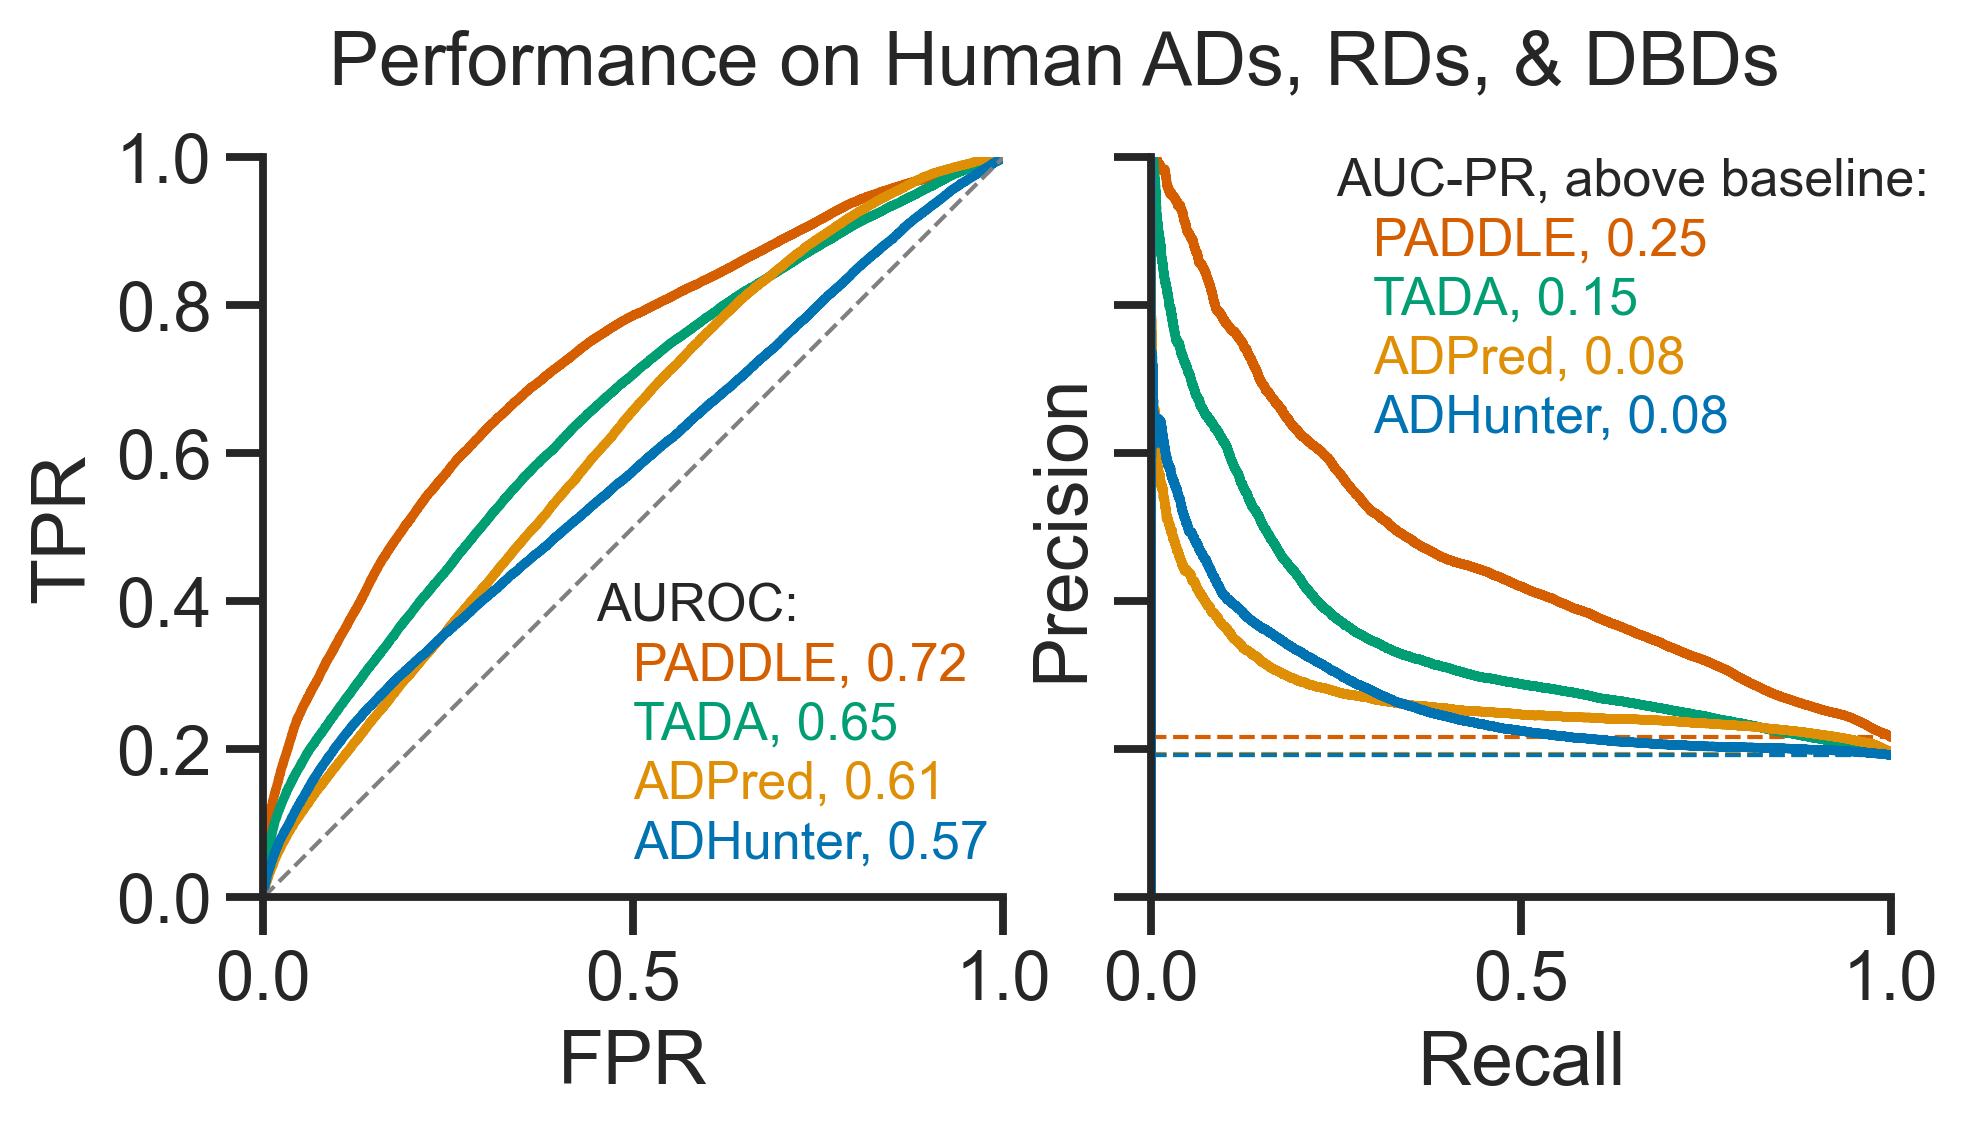

In [185]:
sns.set_context('talk')
sns.set_style('ticks')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4))
    
# Plot Precision-Recall on the first subplot
plt.sca(ax1)  # Switch to ax1

color_palette = sns.color_palette('colorblind')
colors = {"paddle" : color_palette[3],
          "tada" :  color_palette[2],
          "adpred" :  color_palette[1],
          "adhunter" :  color_palette[0]}


# AUC PLOTS

paddle_auc = plot_roc(paddle_ad_rd_dbd, "paddle", colors["paddle"], first = True, text = False)
tada_auc = plot_roc(tada_ad_rd_dbd, "tada", colors["tada"], first = True, text = False)
adpred_auc = plot_roc(adpred_ad_rd_dbd, "adpred", colors["adpred"], first = True, text = False)
adhunter_auc = plot_roc(adhunter_ad_rd_dbd, "adhunter", colors["adhunter"], first = True, text = False)

plt.text(x = 0.45, y = 0.36, s = "AUROC:", ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.28, s = "PADDLE, " + str(round(paddle_auc, 2)), color = colors["paddle"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.20, s = "TADA, " + str(round(tada_auc, 2)), color = colors["tada"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.12, s = "ADPred, " + str(round(adpred_auc, 2)), color = colors["adpred"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.04, s = "ADHunter, " + str(round(adhunter_auc, 2)), color = colors["adhunter"], ha = "left", va = "bottom", fontsize = "x-small")

plt.plot([0, 1], [0, 1], 'k--', color = "gray", lw = 1);

# PRECISION RECALL

plt.sca(ax2)  # Switch to ax2
# all_TF_random_luck = sum(df["active"]) / len(df)
# plt.axhline(all_TF_random_luck, linestyle = '--', color = all_color, lw = 1)

def plot_random_expec(df, color):
    all_TF_random_luck = sum(df["active"]) / len(df)
    plt.axhline(all_TF_random_luck, linestyle = '--', color = color, lw = 1)
    return all_TF_random_luck

paddle_random_expec = plot_random_expec(paddle_ad_rd_dbd, colors["paddle"])
tada_random_expec = plot_random_expec(tada_ad_rd_dbd, colors["tada"])
adpred_random_expec = plot_random_expec(adpred_ad_rd_dbd, colors["adpred"])
adhunter_random_expec = plot_random_expec(adhunter_ad_rd_dbd, colors["adhunter"])

paddle_prc_auc = plot_prc(paddle_ad_rd_dbd, "paddle", colors["paddle"])
tada_prc_auc = plot_prc(tada_ad_rd_dbd, "tada", colors["tada"])
adpred_prc_auc = plot_prc(adpred_ad_rd_dbd, "adpred", colors["adpred"])
adhunter_prc_auc = plot_prc(adhunter_ad_rd_dbd, "adhunter", colors["adhunter"])

plt.text(x = 0.25, y = 1, s = "AUC-PR, above baseline:", ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.92, s = "PADDLE, " + str(round(paddle_prc_auc - paddle_random_expec, 2)),
         color = colors["paddle"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.84, s = "TADA, " + str(round(tada_prc_auc - tada_random_expec, 2)), 
         color = colors["tada"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.76, s = "ADPred, " + str(round(adpred_prc_auc - adpred_random_expec, 2)), 
         color = colors["adpred"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y =0.68, s = "ADHunter, " + str(round(adhunter_prc_auc- adhunter_random_expec, 2)), 
         color = colors["adhunter"], ha = "left", va = "top", fontsize = "x-small")


#add_custom_legend({"All TFs" : all_color, "Activator TFs" :activator_color}, ax = ax2)
plt.subplots_adjust(wspace=0.2, hspace = 0)
plt.text(x = 0.85, y = 1.1, s = "Performance on Human ADs, RDs, & DBDs", ha = "right");


In [186]:
len(paddle_ad_rd_dbd)

184694

In [187]:
len(tada_ad_rd_dbd)

237510

In [188]:
len(adhunter_ad_rd_dbd)

237510

In [189]:
len(adpred_ad_rd_dbd)

227677

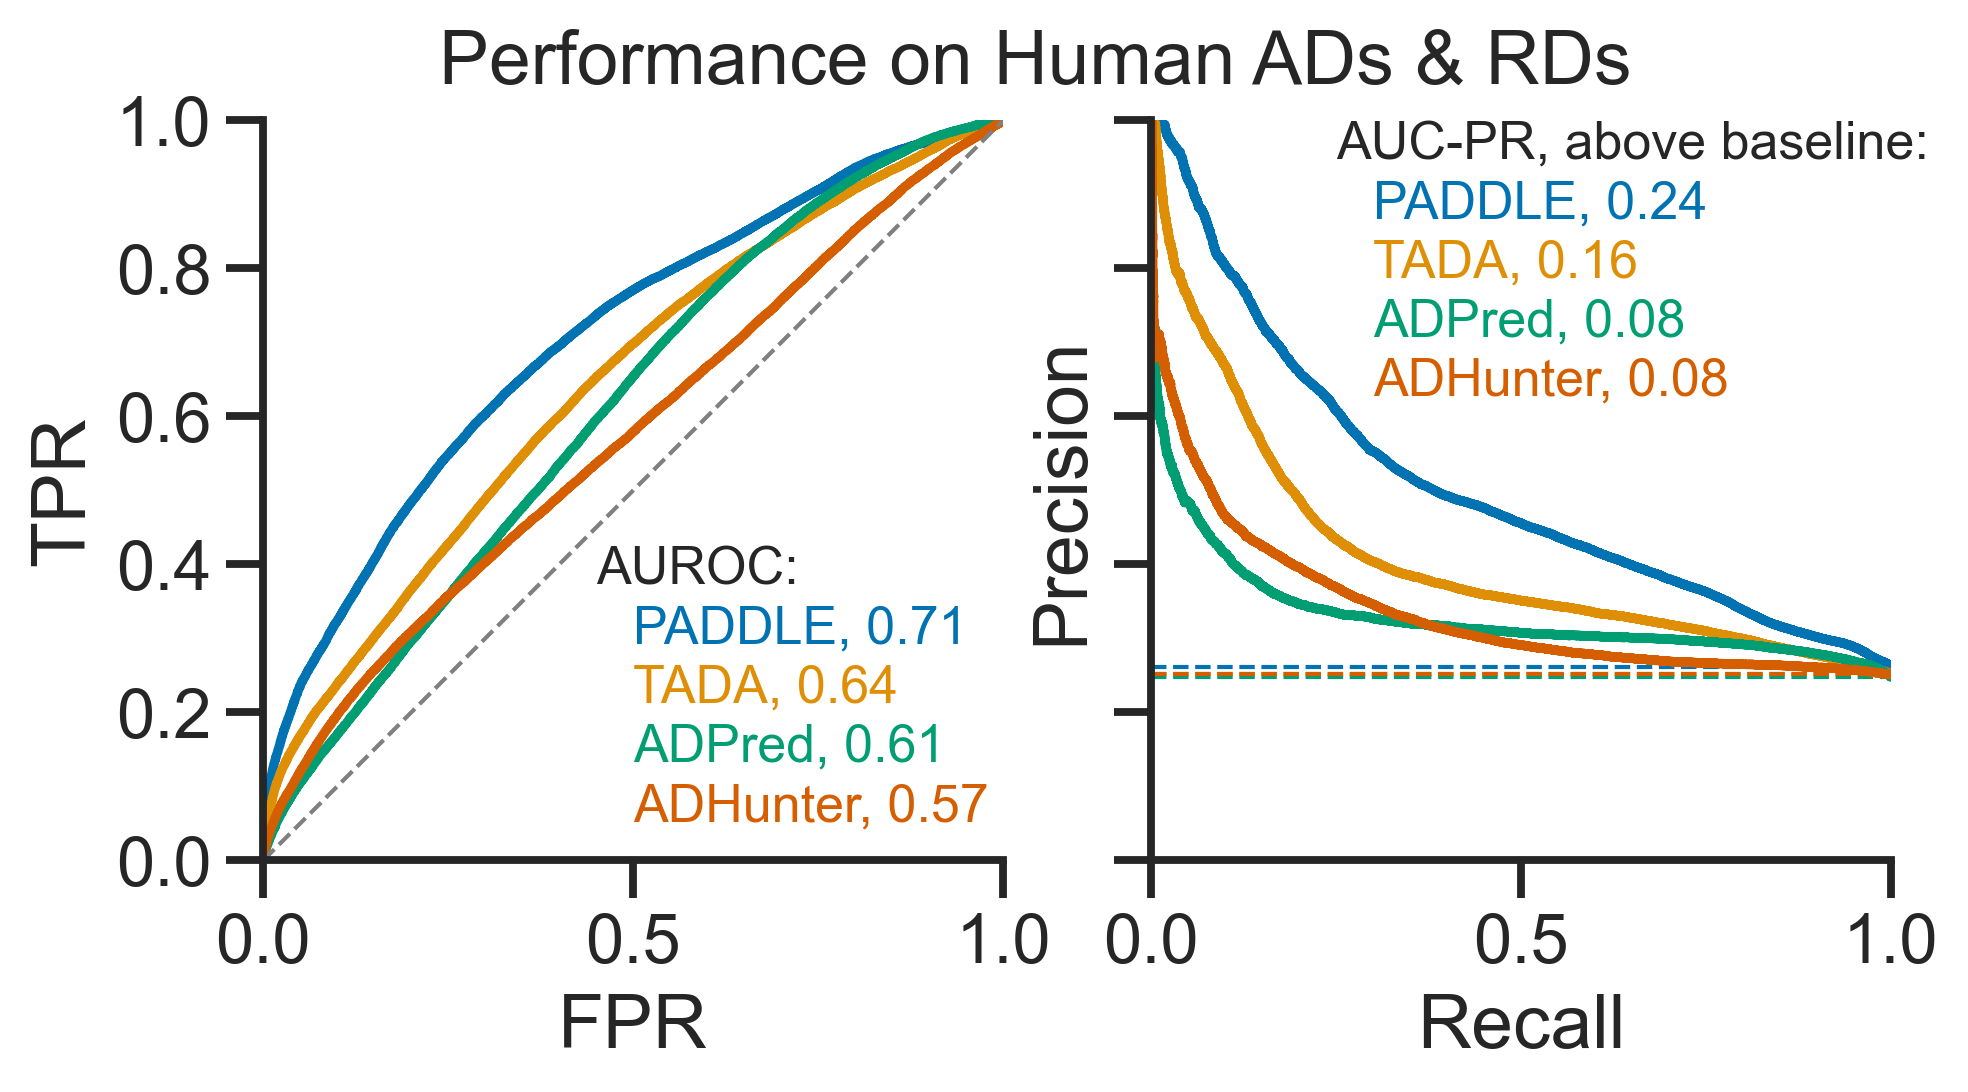

In [190]:
sns.set_context('talk')
sns.set_style('ticks')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4))
    
# Plot Precision-Recall on the first subplot
plt.sca(ax1)  # Switch to ax1

color_palette = sns.color_palette('colorblind')
colors = {"paddle" : color_palette[0],
          "tada" :  color_palette[1],
          "adpred" :  color_palette[2],
          "adhunter" :  color_palette[3]}


# AUC PLOTS

paddle_auc = plot_roc(paddle_ad_rd, "paddle", colors["paddle"], first = True, text = False)
tada_auc = plot_roc(tada_ad_rd, "tada", colors["tada"], first = True, text = False)
adpred_auc = plot_roc(adpred_ad_rd, "adpred", colors["adpred"], first = True, text = False)
adhunter_auc = plot_roc(adhunter_ad_rd, "adhunter", colors["adhunter"], first = True, text = False)

plt.text(x = 0.45, y = 0.36, s = "AUROC:", ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.28, s = "PADDLE, " + str(round(paddle_auc, 2)), color = colors["paddle"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.20, s = "TADA, " + str(round(tada_auc, 2)), color = colors["tada"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.12, s = "ADPred, " + str(round(adpred_auc, 2)), color = colors["adpred"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.04, s = "ADHunter, " + str(round(adhunter_auc, 2)), color = colors["adhunter"], ha = "left", va = "bottom", fontsize = "x-small")

plt.plot([0, 1], [0, 1], 'k--', color = "gray", lw = 1);

# PRECISION RECALL

plt.sca(ax2)  # Switch to ax2
# all_TF_random_luck = sum(df["active"]) / len(df)
# plt.axhline(all_TF_random_luck, linestyle = '--', color = all_color, lw = 1)

def plot_random_expec(df, color):
    all_TF_random_luck = sum(df["active"]) / len(df)
    plt.axhline(all_TF_random_luck, linestyle = '--', color = color, lw = 1)
    return all_TF_random_luck

paddle_random_expec = plot_random_expec(paddle_ad_rd, colors["paddle"])
tada_random_expec = plot_random_expec(tada_ad_rd, colors["tada"])
adpred_random_expec = plot_random_expec(adpred_ad_rd, colors["adpred"])
adhunter_random_expec = plot_random_expec(adhunter_ad_rd, colors["adhunter"])

paddle_prc_auc = plot_prc(paddle_ad_rd, "paddle", colors["paddle"])
tada_prc_auc = plot_prc(tada_ad_rd, "tada", colors["tada"])
adpred_prc_auc = plot_prc(adpred_ad_rd, "adpred", colors["adpred"])
adhunter_prc_auc = plot_prc(adhunter_ad_rd, "adhunter", colors["adhunter"])

plt.text(x = 0.25, y = 1, s = "AUC-PR, above baseline:", ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.92, s = "PADDLE, " + str(round(paddle_prc_auc - paddle_random_expec, 2)),
         color = colors["paddle"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.84, s = "TADA, " + str(round(tada_prc_auc - tada_random_expec, 2)), 
         color = colors["tada"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.76, s = "ADPred, " + str(round(adpred_prc_auc - adpred_random_expec, 2)), 
         color = colors["adpred"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y =0.68, s = "ADHunter, " + str(round(adhunter_prc_auc- adhunter_random_expec, 2)), 
         color = colors["adhunter"], ha = "left", va = "top", fontsize = "x-small")


#add_custom_legend({"All TFs" : all_color, "Activator TFs" :activator_color}, ax = ax2)
plt.subplots_adjust(wspace=0.2, hspace = 0)
plt.text(x = 0.65, y = 1.05, s = "Performance on Human ADs & RDs", ha = "right");


In [191]:
len(paddle_ad_rd)

155416

In [192]:
len(tada_ad_rd)

188217

In [193]:
len(adhunter_ad_rd)

188217

In [194]:
len(adpred_ad_rd)

184431

# 7. AD tiles vs all others

In [195]:
paddle_overlap

,uniprotID,paddle,GeneName,sequence,preds_len,seq_len,center_start,center_end,centers,tile,Start,End,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap
0,P17019,-0.050897,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,26,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,0,53,False,True,False
1,P17019,-0.049498,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,27,KRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKG...,1,54,False,True,False
2,P17019,-0.050370,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,28,RHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGC...,2,55,False,True,False
3,P17019,-0.052431,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,29,HEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCK...,3,56,False,True,False
4,P17019,-0.055883,sp|P17019|ZN708_HUMAN,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,447,499,26,473,30,EMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCKS...,4,57,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747198,O15409,0.497632,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,684,SPGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDRE...,658,711,False,False,False
747199,O15409,0.515655,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,685,PGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREI...,659,712,False,False,False
747200,O15409,0.537844,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,686,GCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIE...,660,713,False,False,False
747201,O15409,0.551399,sp|O15409|FOXP2_HUMAN,MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVST...,663,715,26,689,687,CSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIEE...,661,714,False,False,False


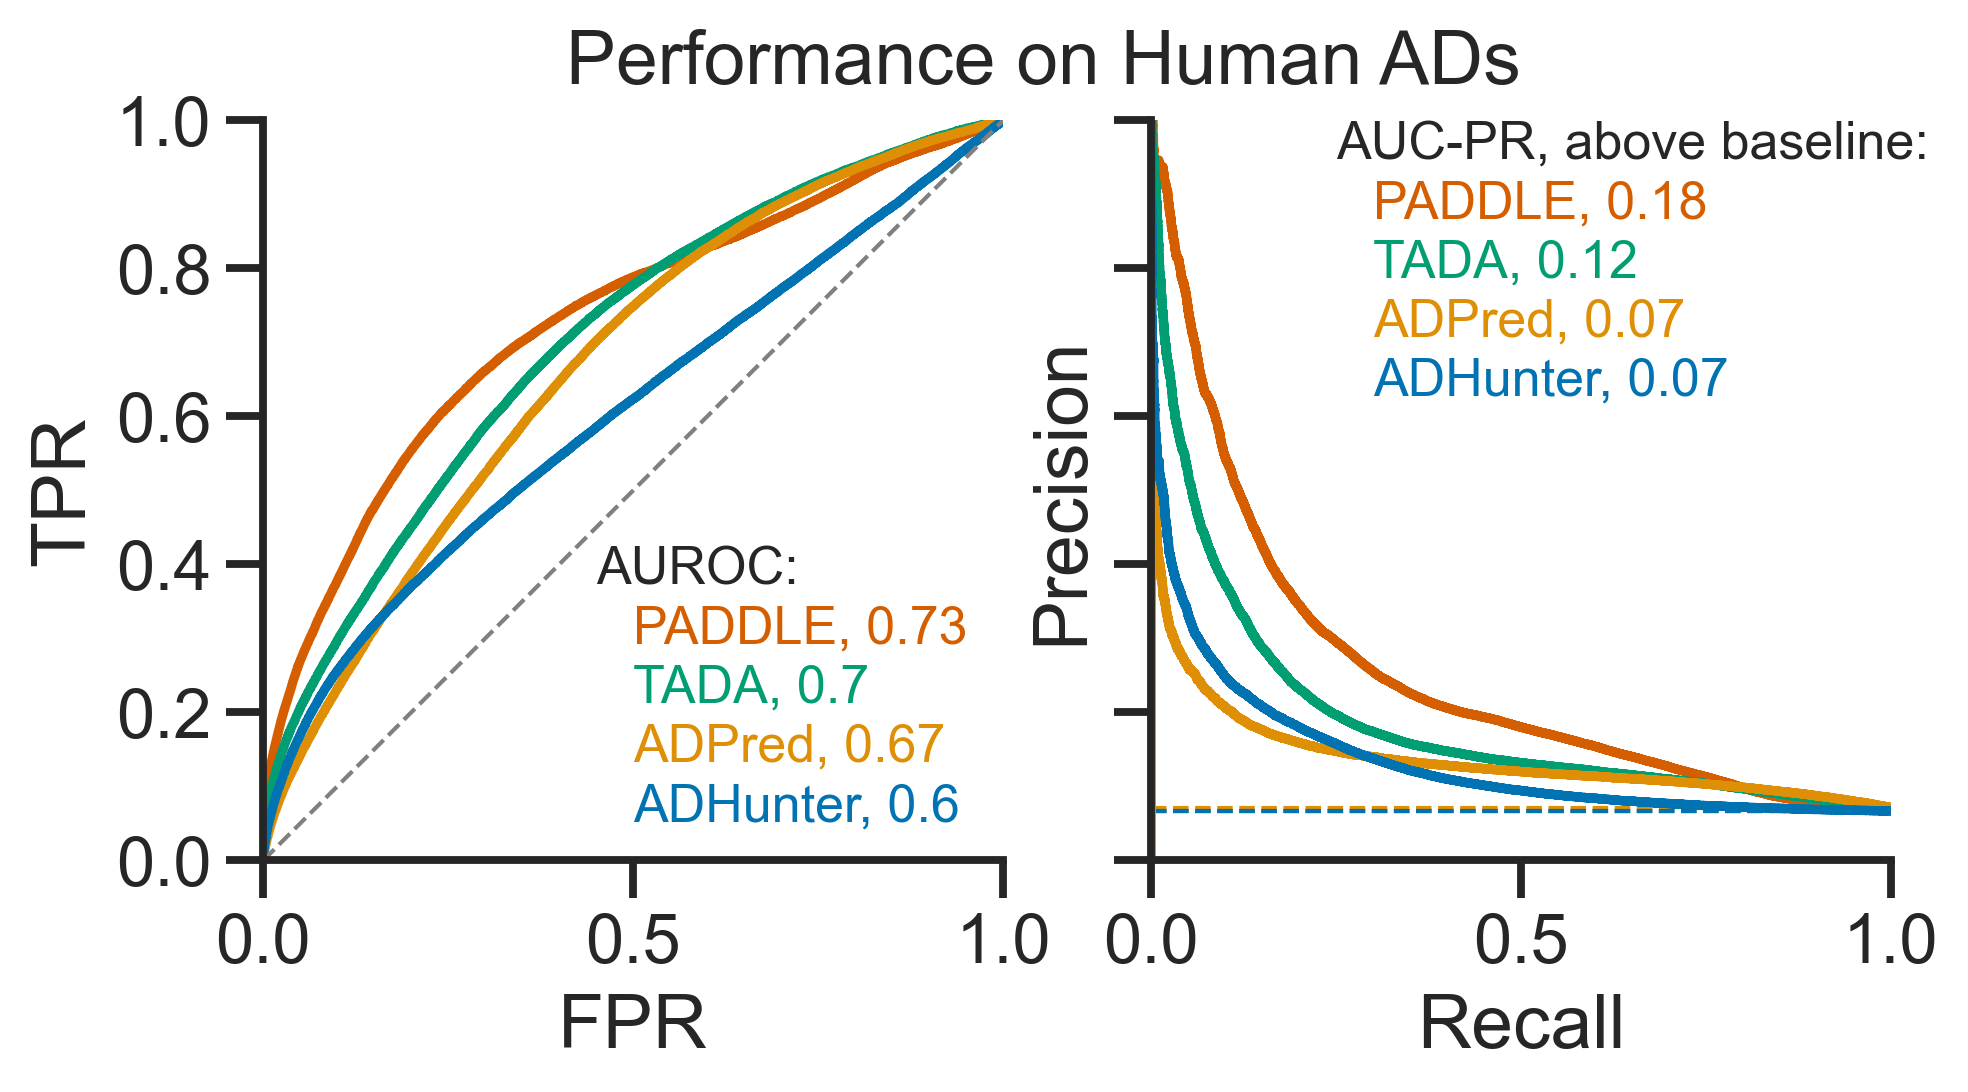

In [196]:
sns.set_context('talk')
sns.set_style('ticks')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4))
    
# Plot Precision-Recall on the first subplot
plt.sca(ax1)  # Switch to ax1

color_palette = sns.color_palette('colorblind')
colors = {"paddle" : color_palette[3],
          "tada" :  color_palette[2],
          "adpred" :  color_palette[1],
          "adhunter" :  color_palette[0]} 


# AUC PLOTS

paddle_auc = plot_roc(paddle_overlap, "paddle", colors["paddle"], first = True, text = False, active_col_name = "AD_suffic_overlap")
tada_auc = plot_roc(tada_overlap, "tada", colors["tada"], first = True, text = False, active_col_name = "AD_suffic_overlap")
adpred_auc = plot_roc(adpred_overlap, "adpred", colors["adpred"], first = True, text = False, active_col_name = "AD_suffic_overlap")
adhunter_auc = plot_roc(adhunter_overlap, "adhunter", colors["adhunter"], first = True, text = False, active_col_name = "AD_suffic_overlap")

plt.text(x = 0.45, y = 0.36, s = "AUROC:", ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.28, s = "PADDLE, " + str(round(paddle_auc, 2)), color = colors["paddle"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.20, s = "TADA, " + str(round(tada_auc, 2)), color = colors["tada"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.12, s = "ADPred, " + str(round(adpred_auc, 2)), color = colors["adpred"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.04, s = "ADHunter, " + str(round(adhunter_auc, 2)), color = colors["adhunter"], ha = "left", va = "bottom", fontsize = "x-small")

plt.plot([0, 1], [0, 1], 'k--', color = "gray", lw = 1);

# PRECISION RECALL

plt.sca(ax2)  # Switch to ax2
# all_TF_random_luck = sum(df["active"]) / len(df)
# plt.axhline(all_TF_random_luck, linestyle = '--', color = all_color, lw = 1)

def plot_random_expec(df, color):
    all_TF_random_luck = sum(df["AD_suffic_overlap"]) / len(df)
    plt.axhline(all_TF_random_luck, linestyle = '--', color = color, lw = 1)
    return all_TF_random_luck

paddle_random_expec = plot_random_expec(paddle_overlap, colors["paddle"])
tada_random_expec = plot_random_expec(tada_overlap, colors["tada"])
adpred_random_expec = plot_random_expec(adpred_overlap, colors["adpred"])
adhunter_random_expec = plot_random_expec(adhunter_overlap, colors["adhunter"])

paddle_prc_auc = plot_prc(paddle_overlap, "paddle", colors["paddle"], active_col_name = "AD_suffic_overlap")
tada_prc_auc = plot_prc(tada_overlap, "tada", colors["tada"], active_col_name = "AD_suffic_overlap")
adpred_prc_auc = plot_prc(adpred_overlap, "adpred", colors["adpred"], active_col_name = "AD_suffic_overlap")
adhunter_prc_auc = plot_prc(adhunter_overlap, "adhunter", colors["adhunter"], active_col_name = "AD_suffic_overlap")

plt.text(x = 0.25, y = 1, s = "AUC-PR, above baseline:", ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.92, s = "PADDLE, " + str(round(paddle_prc_auc - paddle_random_expec, 2)),
         color = colors["paddle"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.84, s = "TADA, " + str(round(tada_prc_auc - tada_random_expec, 2)), 
         color = colors["tada"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.76, s = "ADPred, " + str(round(adpred_prc_auc - adpred_random_expec, 2)), 
         color = colors["adpred"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y =0.68, s = "ADHunter, " + str(round(adhunter_prc_auc- adhunter_random_expec, 2)), 
         color = colors["adhunter"], ha = "left", va = "top", fontsize = "x-small")


#add_custom_legend({"All TFs" : all_color, "Activator TFs" :activator_color}, ax = ax2)
plt.subplots_adjust(wspace=0.2, hspace = 0)
plt.text(x = 0.5, y = 1.05, s = "Performance on Human ADs", ha = "right");


In [197]:
paddle_random_expec

0.06699785734264986

In [198]:
tada_random_expec

0.06655292042158102

In [199]:
adpred_random_expec

0.07122030900739358

In [200]:
adhunter_random_expec

0.06655292042158102

# 8. Acidic ADs

- Add overlap of tiles with list of acidic ADs
- Drop non acidic ADs

In [111]:
known_ADs["charge"] = known_ADs["ProteinRegionSeq"].str.count("R") +  known_ADs["ProteinRegionSeq"].str.count("K") -  known_ADs["ProteinRegionSeq"].str.count("D") -  known_ADs["ProteinRegionSeq"].str.count("E")
acidic_known_ADs = known_ADs[known_ADs["charge"] < -3]
acidic_known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,charge
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN,-23
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN,-36
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN,-20
6,AIRE,292,545,O43918,[['O43918']],NaN,O43918,"PMID: 11274163, Soto",TF,HQKNEDECAVCRDGGELICCDGCPRAFHLACLSPPLREIPSGTWRC...,NaN,-10
8,AKAP8L,1,384,Q9ULX6,"[['Q9ULX6'], ['Q9ULX6'], ['Q9ULX6']]",nan / nan / ENST00000397410,Q9ULX6 / Q9ULX6 / Q9ULX6,"PMID: 11402034, Soto / activation_regions.txt,...",TF,MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTWNSGTNRGYEGYG...,NaN,-13
...,...,...,...,...,...,...,...,...,...,...,...,...
753,ZSCAN20,262,341,P17040,"[['P17040', 'P17040-3']]",ENST00000361328,P17040,DelRosso et al.,TF,PSNTSEKEQGPEFWGLSLINSGKRSTADYSLDNEPAQALTWRDSRA...,NaN,-8
754,ZXDA,572,699,P98168,"[['P98168'], ['P98168']]",nan / nan,P98168 / P98168 / P98168,"PMID: 17493635, Soto / R4TA_regions.txt / acti...",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN,-6


In [112]:
acidic_known_ADs_coords = acidic_known_ADs[["uniprotID", "Start", "End"]]
acidic_known_ADs_coords = acidic_known_ADs_coords.rename(columns = {"Start" : "annot_Start", "End" : "annot_End"})
acidic_known_ADs_coords = acidic_known_ADs_coords.reset_index(drop = True)
acidic_known_ADs_coords

,uniprotID,annot_Start,annot_End
0,Q8IUX7,1088,1158
1,Q8WYP5,1445,1698
2,P35869,532,848
3,O43918,292,545
4,Q9ULX6,1,384
...,...,...,...
360,P17040,262,341
361,P98168,572,699
362,P98169,576,703
363,Q2QGD7,579,688


In [113]:
adhunter_overlap = add_overlap_status(adhunter_overlap, acidic_known_ADs_coords, "acidic_AD", min_overlap = 32)
tada_overlap = add_overlap_status(tada_overlap, acidic_known_ADs_coords, "acidic_AD", min_overlap = 32)
adpred_overlap = add_overlap_status(adpred_overlap, acidic_known_ADs_coords, "acidic_AD", min_overlap = 24)
paddle_overlap = add_overlap_status(paddle_overlap, acidic_known_ADs_coords, "acidic_AD", min_overlap = 42)

In [ ]:
adhunter_overlap.to_csv("../output/TF_pred_output_MZ/adhunter_with_acidicAD_overlap.csv") 
display(adhunter_overlap)

tada_overlap.to_csv("../output/TF_pred_output_MZ/tada_with_acidicAD_overlap.csv") 
display(tada_overlap)

adpred_overlap_to_save = adpred_overlap[["tile", "preds", "GeneName", "Start", "End", "uniprotID", "AD_suffic_overlap", "RD_suffic_overlap", "DBD_suffic_overlap", "acidic_AD_suffic_overlap"]].rename(columns = {"preds" : "adpred"})
adpred_overlap.to_csv("../output/TF_pred_output_MZ/adpred_with_acidicAD_overlap.csv") 
display(adpred_overlap_to_save)

paddle_overlap[["uniprotID", "paddle", "GeneName", "tile", "Start", "End", "AD_suffic_overlap", "RD_suffic_overlap", "DBD_suffic_overlap", "acidic_AD_suffic_overlap"]].to_csv("../output/TF_pred_output_MZ/paddle_with_acidicAD_overlap.csv")
display(paddle_overlap[["uniprotID", "paddle", "GeneName", "tile", "Start", "End", "AD_suffic_overlap", "RD_suffic_overlap", "DBD_suffic_overlap", "acidic_AD_suffic_overlap"]])

,tile,adhunter,GeneName,Start,End,uniprotID,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap,acidic_AD_suffic_overlap
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,39243.560,sp|P23511|NFYA_HUMAN,0,40,P23511,True,False,False,False
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,53384.637,sp|P23511|NFYA_HUMAN,1,41,P23511,True,False,False,False
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,52118.496,sp|P23511|NFYA_HUMAN,2,42,P23511,True,False,False,False
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,43326.395,sp|P23511|NFYA_HUMAN,3,43,P23511,True,False,False,False
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,46656.620,sp|P23511|NFYA_HUMAN,4,44,P23511,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,45052.760,sp|Q9Y5X4|NR2E3_HUMAN,366,406,Q9Y5X4,False,True,False,False
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,50140.586,sp|Q9Y5X4|NR2E3_HUMAN,367,407,Q9Y5X4,False,True,False,False
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,50458.750,sp|Q9Y5X4|NR2E3_HUMAN,368,408,Q9Y5X4,False,True,False,False
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,50317.457,sp|Q9Y5X4|NR2E3_HUMAN,369,409,Q9Y5X4,False,True,False,False


,uniprotID,tile,Start,End,tada,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap,acidic_AD_suffic_overlap
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0,40,0.159213,True,False,False,False
1,P23511,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,1,41,0.158835,True,False,False,False
2,P23511,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,2,42,0.159775,True,False,False,False
3,P23511,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,3,43,0.157610,True,False,False,False
4,P23511,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,4,44,0.157809,True,False,False,False
...,...,...,...,...,...,...,...,...,...
879731,Q9Y5X4,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,366,406,0.171706,False,True,False,False
879732,Q9Y5X4,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,367,407,0.176539,False,True,False,False
879733,Q9Y5X4,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,368,408,0.187182,False,True,False,False
879734,Q9Y5X4,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,369,409,0.190598,False,True,False,False


In [114]:
acidic_known_ADs_coords

,uniprotID,annot_Start,annot_End
0,Q8IUX7,1088,1158
1,Q8WYP5,1445,1698
2,P35869,532,848
3,O43918,292,545
4,Q9ULX6,1,384
...,...,...,...
360,P17040,262,341
361,P98168,572,699
362,P98169,576,703
363,Q2QGD7,579,688


In [115]:
print(sum(adhunter_overlap["acidic_AD_suffic_overlap"]))
print(sum(tada_overlap["acidic_AD_suffic_overlap"]))
print(sum(adpred_overlap["acidic_AD_suffic_overlap"]))
print(sum(paddle_overlap["acidic_AD_suffic_overlap"]))

38698
38698
38318
33034


In [213]:
# Only keep AD annotations which are acidic
acidic_tada = tada_overlap[~(tada_overlap["AD_suffic_overlap"] != tada_overlap["acidic_AD_suffic_overlap"])]
acidic_adpred = adpred_overlap[~(adpred_overlap["AD_suffic_overlap"] != adpred_overlap["acidic_AD_suffic_overlap"])]
acidic_paddle = paddle_overlap[~(paddle_overlap["AD_suffic_overlap"] != paddle_overlap["acidic_AD_suffic_overlap"])]
acidic_adhunter = adhunter_overlap[~(adhunter_overlap["AD_suffic_overlap"] != adhunter_overlap["acidic_AD_suffic_overlap"])]

In [217]:
print(len(acidic_tada))
print(len(acidic_adpred))
print(len(acidic_paddle))
print(len(acidic_adhunter))

859885
794549
730176
859885


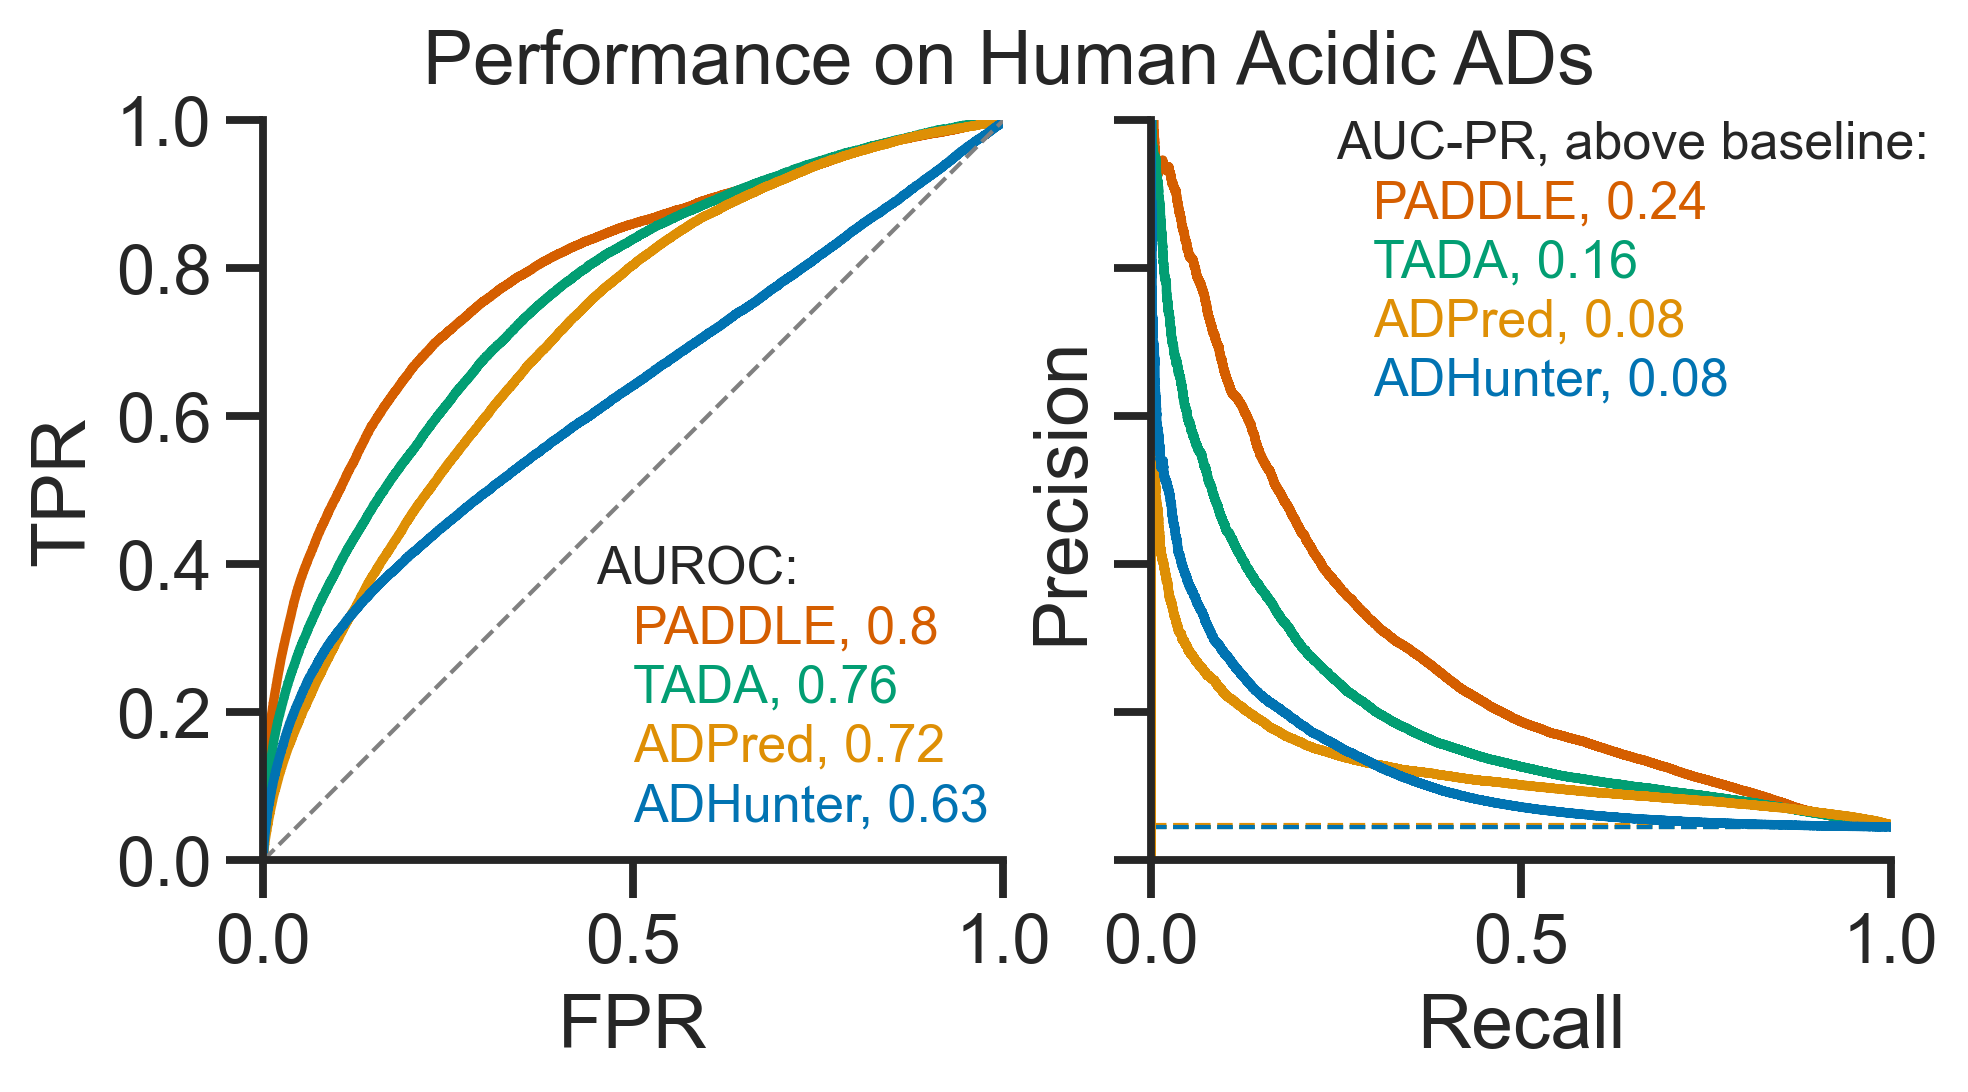

In [220]:
sns.set_context('talk')
sns.set_style('ticks')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4))
    
# Plot Precision-Recall on the first subplot
plt.sca(ax1)  # Switch to ax1

color_palette = sns.color_palette('colorblind')
colors = {"paddle" : color_palette[3],
          "tada" :  color_palette[2],
          "adpred" :  color_palette[1],
          "adhunter" :  color_palette[0]} 


# AUC PLOTS

paddle_auc = plot_roc(acidic_paddle, "paddle", colors["paddle"], first = True, text = False, active_col_name = "AD_suffic_overlap")
tada_auc = plot_roc(acidic_tada, "tada", colors["tada"], first = True, text = False, active_col_name = "AD_suffic_overlap")
adpred_auc = plot_roc(acidic_adpred, "adpred", colors["adpred"], first = True, text = False, active_col_name = "AD_suffic_overlap")
adhunter_auc = plot_roc(acidic_adhunter, "adhunter", colors["adhunter"], first = True, text = False, active_col_name = "AD_suffic_overlap")

plt.text(x = 0.45, y = 0.36, s = "AUROC:", ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.28, s = "PADDLE, " + str(round(paddle_auc, 2)), color = colors["paddle"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.20, s = "TADA, " + str(round(tada_auc, 2)), color = colors["tada"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.12, s = "ADPred, " + str(round(adpred_auc, 2)), color = colors["adpred"], ha = "left", va = "bottom", fontsize = "x-small")
plt.text(x = 0.5, y = 0.04, s = "ADHunter, " + str(round(adhunter_auc, 2)), color = colors["adhunter"], ha = "left", va = "bottom", fontsize = "x-small")

plt.plot([0, 1], [0, 1], 'k--', color = "gray", lw = 1);

# PRECISION RECALL

plt.sca(ax2)  # Switch to ax2
# all_TF_random_luck = sum(df["active"]) / len(df)
# plt.axhline(all_TF_random_luck, linestyle = '--', color = all_color, lw = 1)

def plot_random_expec(df, color):
    all_TF_random_luck = sum(df["AD_suffic_overlap"]) / len(df)
    plt.axhline(all_TF_random_luck, linestyle = '--', color = color, lw = 1)
    return all_TF_random_luck

paddle_random_expec = plot_random_expec(acidic_paddle, colors["paddle"])
tada_random_expec = plot_random_expec(acidic_tada, colors["tada"])
adpred_random_expec = plot_random_expec(acidic_adpred, colors["adpred"])
adhunter_random_expec = plot_random_expec(acidic_adhunter, colors["adhunter"])

paddle_prc_auc = plot_prc(acidic_paddle, "paddle", colors["paddle"], active_col_name = "AD_suffic_overlap")
tada_prc_auc = plot_prc(acidic_tada, "tada", colors["tada"], active_col_name = "AD_suffic_overlap")
adpred_prc_auc = plot_prc(acidic_adpred, "adpred", colors["adpred"], active_col_name = "AD_suffic_overlap")
adhunter_prc_auc = plot_prc(acidic_adhunter, "adhunter", colors["adhunter"], active_col_name = "AD_suffic_overlap")

plt.text(x = 0.25, y = 1, s = "AUC-PR, above baseline:", ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.92, s = "PADDLE, " + str(round(paddle_prc_auc - paddle_random_expec, 2)),
         color = colors["paddle"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.84, s = "TADA, " + str(round(tada_prc_auc - tada_random_expec, 2)), 
         color = colors["tada"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y = 0.76, s = "ADPred, " + str(round(adpred_prc_auc - adpred_random_expec, 2)), 
         color = colors["adpred"], ha = "left", va = "top", fontsize = "x-small")
plt.text(x = 0.3, y =0.68, s = "ADHunter, " + str(round(adhunter_prc_auc- adhunter_random_expec, 2)), 
         color = colors["adhunter"], ha = "left", va = "top", fontsize = "x-small")


#add_custom_legend({"All TFs" : all_color, "Activator TFs" :activator_color}, ax = ax2)
plt.subplots_adjust(wspace=0.2, hspace = 0)
plt.text(x = 0.6, y = 1.05, s = "Performance on Human Acidic ADs", ha = "right");


# 7. misc EDA

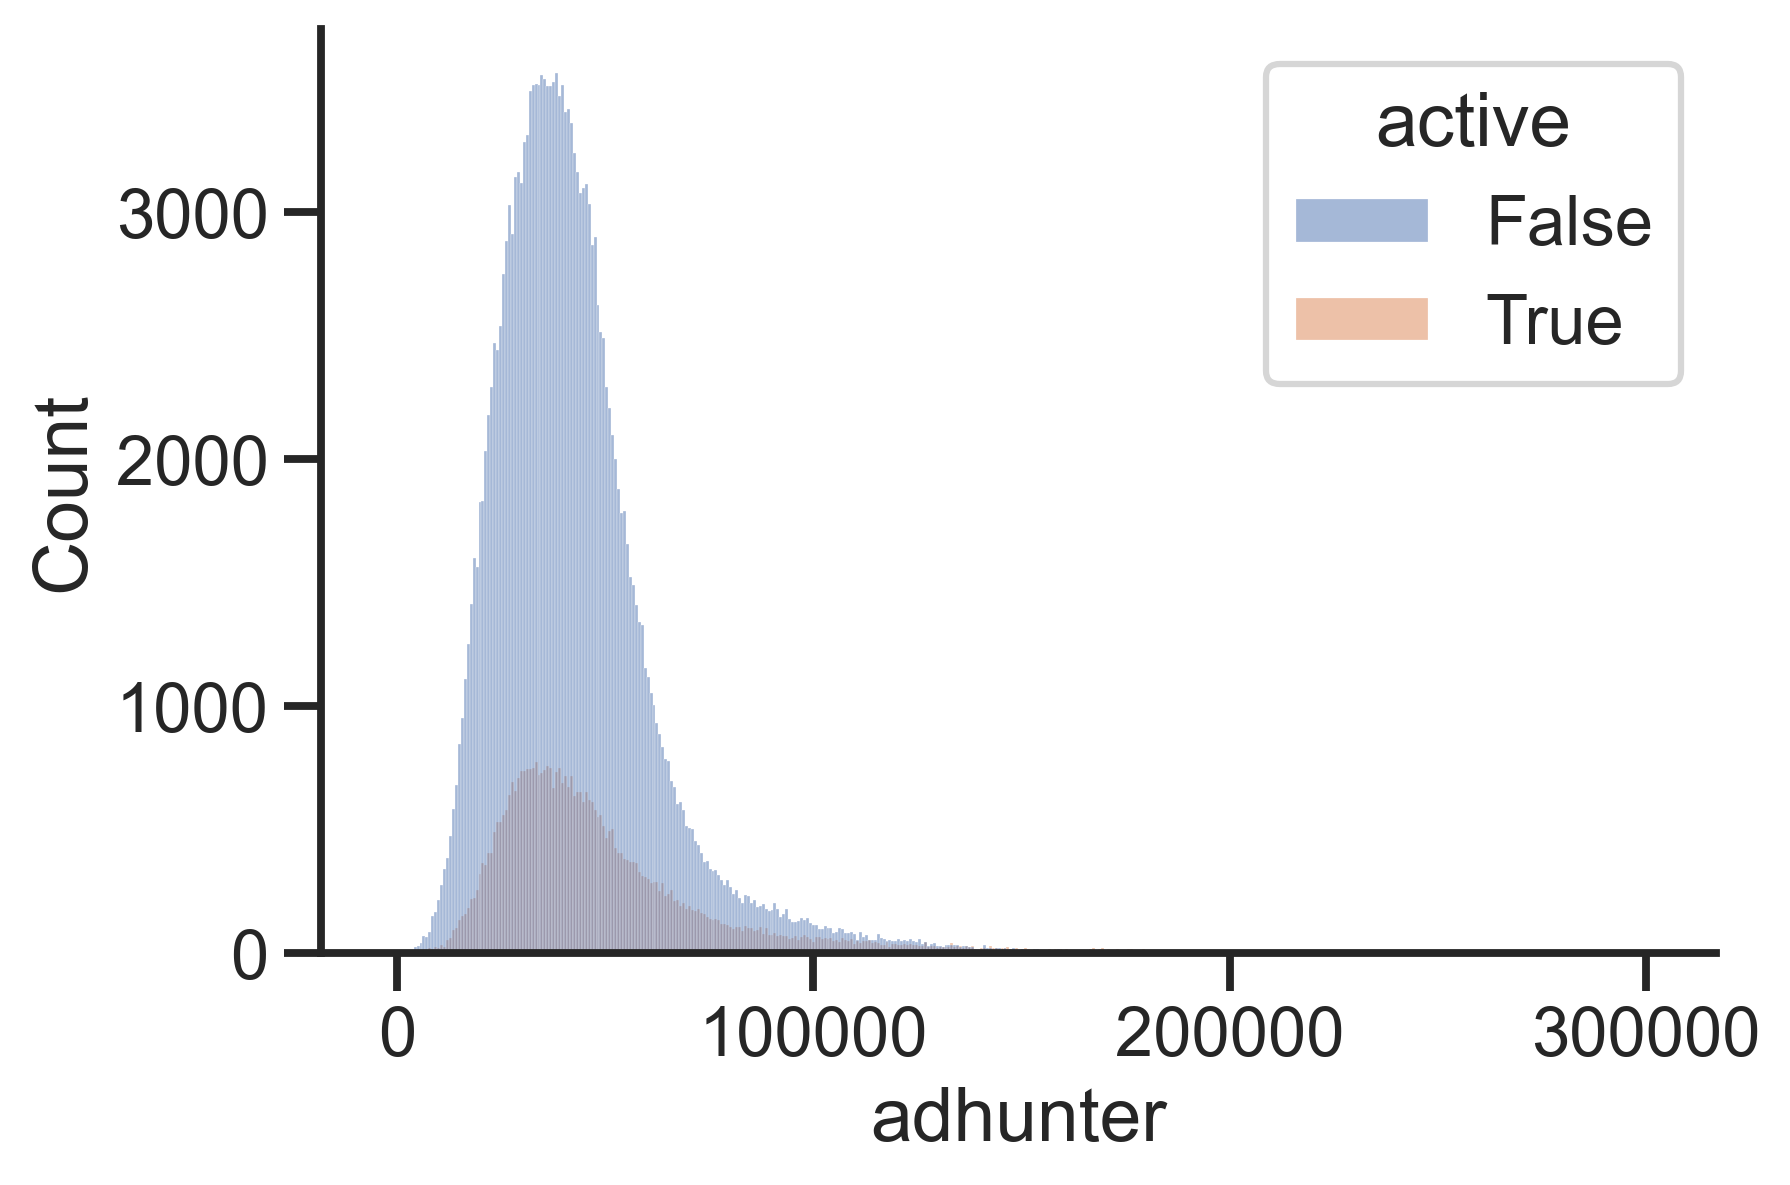

In [129]:
sns.histplot(data = adhunter_ad_rd_dbd, x = "adhunter", hue = "active")
sns.despine();

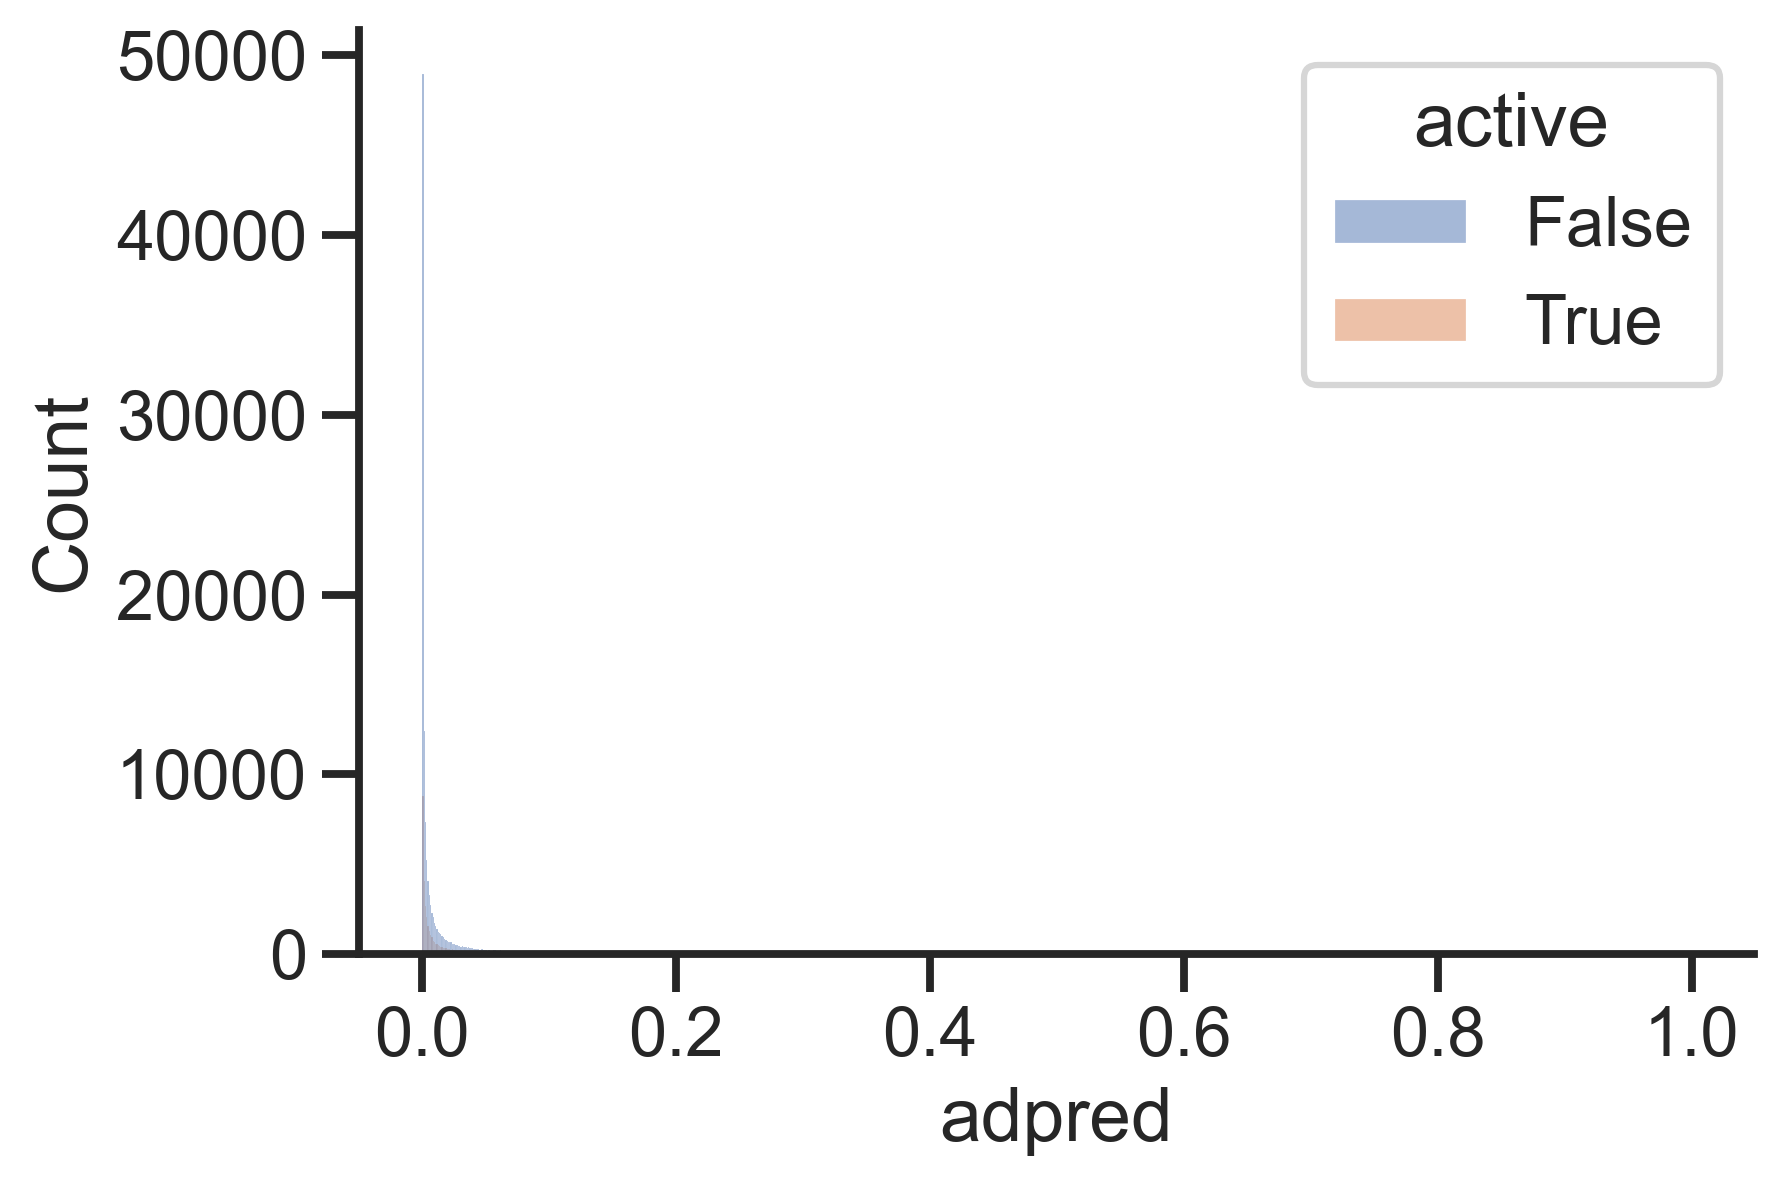

In [124]:
sns.histplot(data = adpred_ad_rd_dbd, x = "adpred", hue = "active", bins = 1000)
sns.despine();

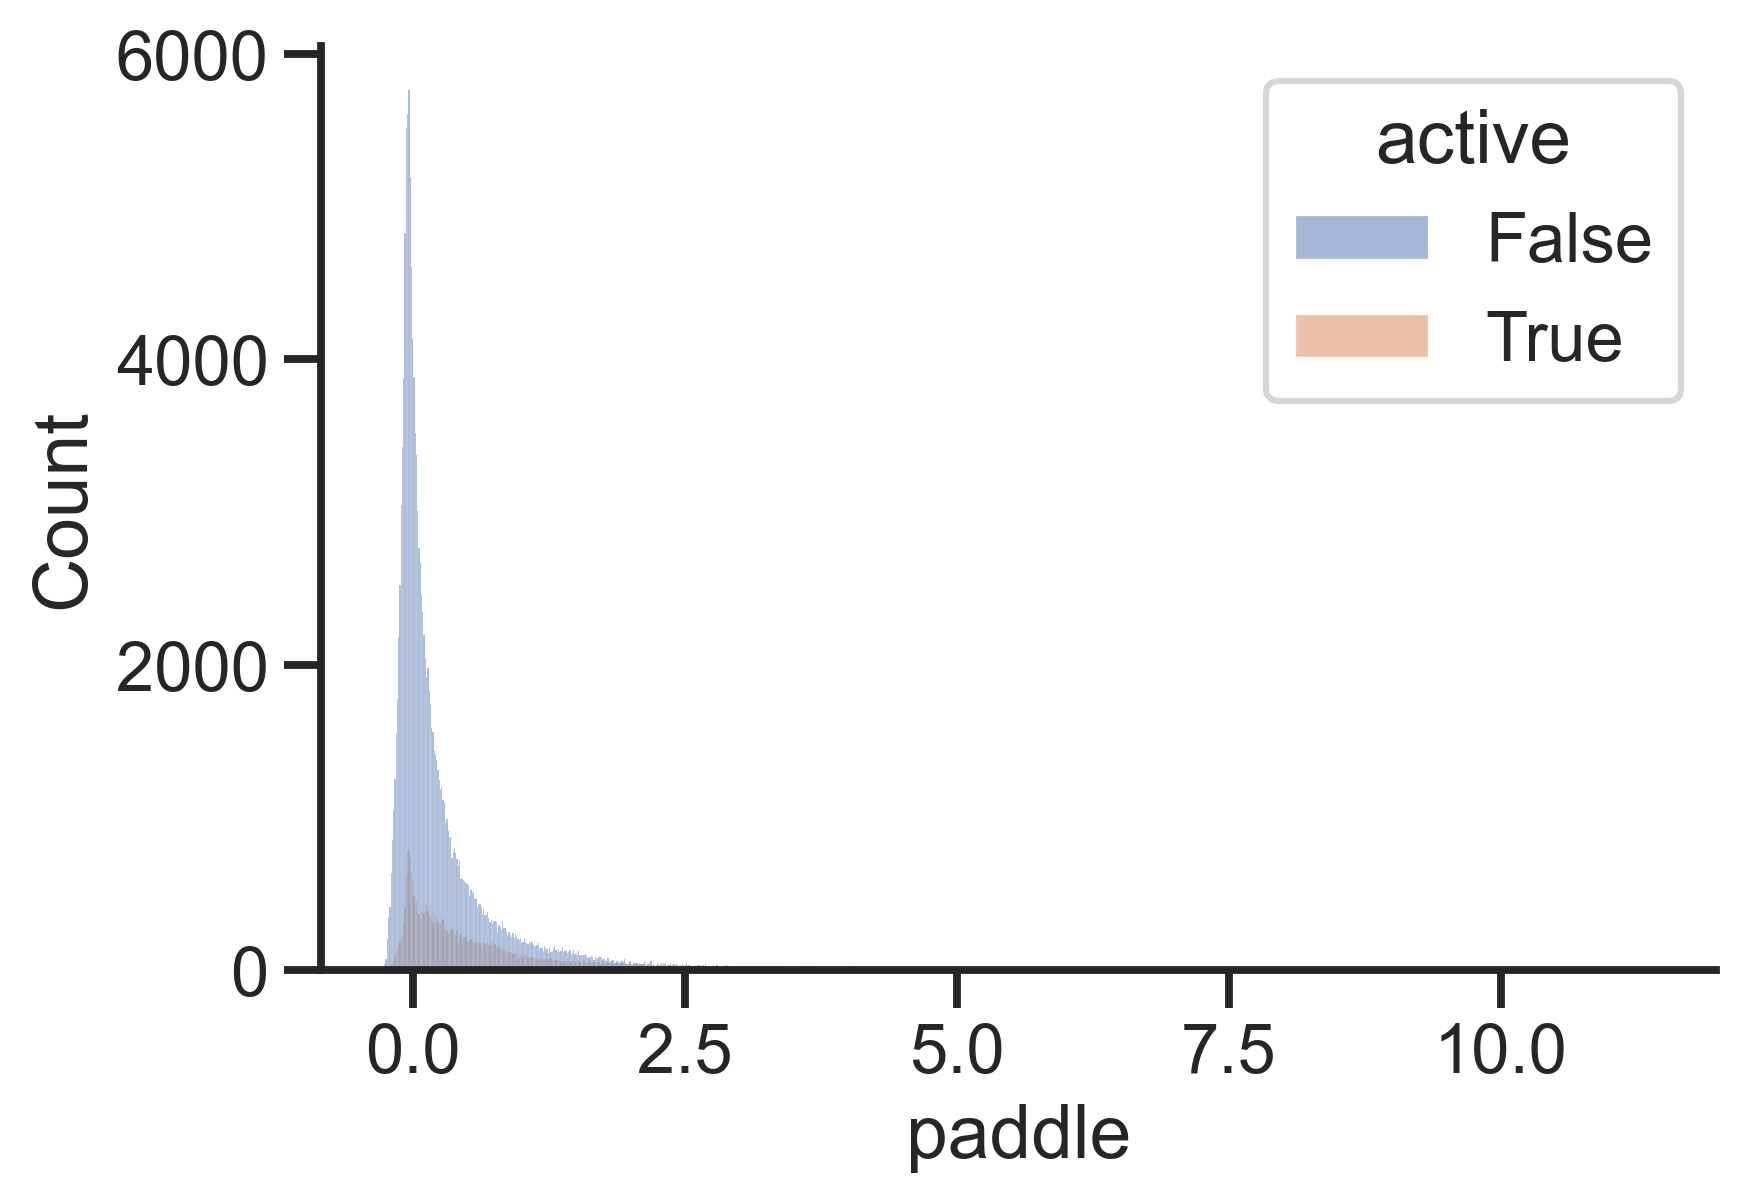

In [125]:
sns.histplot(data = paddle_ad_rd_dbd, x = "paddle", hue = "active", bins = 1000)
sns.despine();

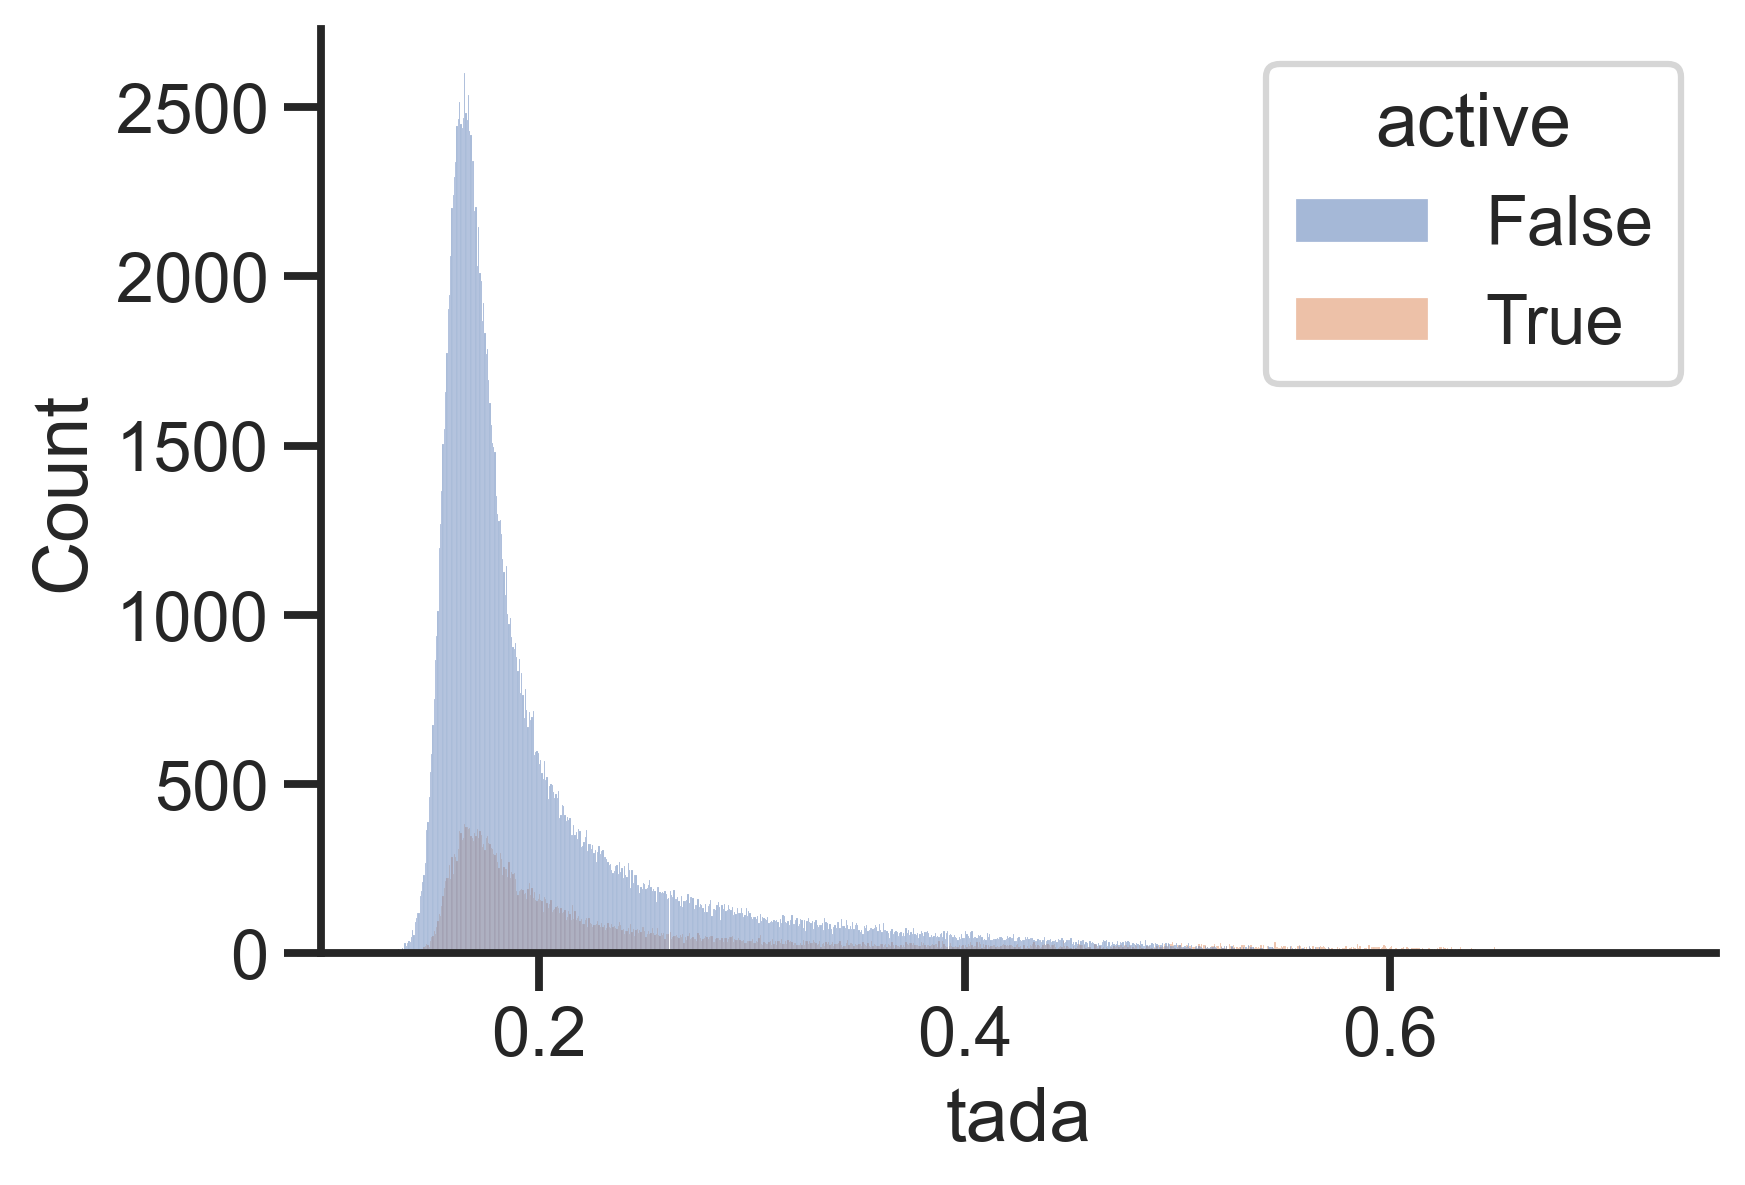

In [126]:
sns.histplot(data = tada_ad_rd_dbd, x = "tada", hue = "active", bins = 1000)
sns.despine();

In [150]:
adhunter_ad_rd_dbd

,tile,adhunter,GeneName,Start,End,uniprotID,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap,annot_count,active
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,39243.560,sp|P23511|NFYA_HUMAN,0,40,P23511,True,False,False,1,True
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,53384.637,sp|P23511|NFYA_HUMAN,1,41,P23511,True,False,False,1,True
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,52118.496,sp|P23511|NFYA_HUMAN,2,42,P23511,True,False,False,1,True
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,43326.395,sp|P23511|NFYA_HUMAN,3,43,P23511,True,False,False,1,True
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,46656.620,sp|P23511|NFYA_HUMAN,4,44,P23511,True,False,False,1,True
...,...,...,...,...,...,...,...,...,...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,45052.760,sp|Q9Y5X4|NR2E3_HUMAN,366,406,Q9Y5X4,False,True,False,1,False
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,50140.586,sp|Q9Y5X4|NR2E3_HUMAN,367,407,Q9Y5X4,False,True,False,1,False
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,50458.750,sp|Q9Y5X4|NR2E3_HUMAN,368,408,Q9Y5X4,False,True,False,1,False
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,50317.457,sp|Q9Y5X4|NR2E3_HUMAN,369,409,Q9Y5X4,False,True,False,1,False


In [153]:
adhunter_overlap

,tile,adhunter,GeneName,Start,End,uniprotID,AD_suffic_overlap,RD_suffic_overlap,DBD_suffic_overlap
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,39243.560,sp|P23511|NFYA_HUMAN,0,40,P23511,True,False,False
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,53384.637,sp|P23511|NFYA_HUMAN,1,41,P23511,True,False,False
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,52118.496,sp|P23511|NFYA_HUMAN,2,42,P23511,True,False,False
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,43326.395,sp|P23511|NFYA_HUMAN,3,43,P23511,True,False,False
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,46656.620,sp|P23511|NFYA_HUMAN,4,44,P23511,True,False,False
...,...,...,...,...,...,...,...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,45052.760,sp|Q9Y5X4|NR2E3_HUMAN,366,406,Q9Y5X4,False,True,False
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,50140.586,sp|Q9Y5X4|NR2E3_HUMAN,367,407,Q9Y5X4,False,True,False
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,50458.750,sp|Q9Y5X4|NR2E3_HUMAN,368,408,Q9Y5X4,False,True,False
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,50317.457,sp|Q9Y5X4|NR2E3_HUMAN,369,409,Q9Y5X4,False,True,False
